In [1]:
import vectorbt as vbt
from vectorbt.portfolio.enums import *

import numpy as np
import pandas as pd
from numba import njit
from datetime import datetime, timedelta

seed = 42

price = pd.Series([1., 2., 3., 4., 5.], index=pd.Index([
    datetime(2020, 1, 1),
    datetime(2020, 1, 2),
    datetime(2020, 1, 3),
    datetime(2020, 1, 4),
    datetime(2020, 1, 5)
]))
price_wide = price.vbt.tile(3, keys=['a', 'b', 'c'])
print(price.shape, price_wide.shape)

big_price = pd.DataFrame(np.random.uniform(size=(1000,)))
big_price.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_price_wide = big_price.vbt.tile(1000)
print(big_price.shape, big_price_wide.shape)

# Disable caching for performance testing
# NOTE: Expect waterfall of executions, since some attributes depend on other attributes 
# that have to be calculated again and again
vbt.defaults.caching['properties'] = False
vbt.defaults.caching['methods'] = False

(5,) (5, 3)
(1000, 1) (1000, 1000)


## from_signals

In [2]:
entries = pd.Series([True, True, True, False, False], index=price.index)
entries_wide = entries.vbt.tile(3, keys=['a', 'b', 'c'])
print(entries.shape, entries_wide.shape)

exits = pd.Series([False, False, True, True, True], index=price.index)
exits_wide = exits.vbt.tile(3, keys=['a', 'b', 'c'])
print(exits.shape, exits_wide.shape)

big_entries = pd.DataFrame.vbt.signals.empty((1000,), index=big_price.index)
big_entries.iloc[0::2] = True
big_entries_wide = big_entries.vbt.tile(1000)
print(big_entries.shape, big_entries_wide.shape)

big_exits = pd.DataFrame.vbt.signals.empty((1000,), index=big_price.index)
big_exits.iloc[1::2] = True
big_exits_wide = big_exits.vbt.tile(1000)
print(big_exits.shape, big_exits_wide.shape)

(5,) (5, 3)
(5,) (5, 3)
(1000,) (1000, 1000)
(1000,) (1000, 1000)


In [3]:
%timeit vbt.Portfolio.from_signals(\
    big_price, big_entries, big_exits,\
    size=1., init_cash=np.inf, accumulate=True)

2.14 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, accumulate=True)

119 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, accumulate=True, log=True)

289 ms ± 97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, accumulate=True,\
    group_by=np.repeat(np.arange(500), 2))

114 ms ± 5.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, accumulate=True,\
    group_by=np.repeat(np.arange(500), 2), cash_sharing=True)

114 ms ± 5.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
# worst case
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=np.arange(1000)[::-1], init_cash=np.inf, accumulate=True,\
    group_by=np.repeat(np.arange(500), 2), cash_sharing=True, call_seq=CallSeqType.Auto)

146 ms ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, accumulate=True,\
    group_by=np.full(1000, 0))

106 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, accumulate=True,\
    group_by=np.full(1000, 0), cash_sharing=True)

105 ms ± 6.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
# worst case
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=np.arange(1000)[::-1], init_cash=np.inf, accumulate=True,\
    group_by=np.full(1000, 0), cash_sharing=True, call_seq=CallSeqType.Auto)

634 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
def test_per_direction(price=price, entries=entries, exits=exits, **kwargs):
    print('All')
    try:
        portfolio = vbt.Portfolio.from_signals(price, entries, exits, direction='all', **kwargs)
        print(portfolio.orders().records)
    except Exception as e:
        print(e)
    print('LongOnly')
    try:
        portfolio = vbt.Portfolio.from_signals(price, entries, exits, direction='longonly', **kwargs)
        print(portfolio.orders().records)
    except Exception as e:
        print(e)
    print('ShortOnly')
    try:
        portfolio = vbt.Portfolio.from_signals(price, entries, exits, direction='shortonly', **kwargs)
        print(portfolio.orders().records)
    except Exception as e:
        print(e)

In [4]:
test_per_direction()

All
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    0    3  200.0    4.0   0.0     1
LongOnly
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    0    3  100.0    4.0   0.0     1
ShortOnly
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     1
1    0    3   50.0    4.0   0.0     0


In [14]:
test_per_direction(size=[[-1, 0, np.inf]])

All
   col  idx   size  price  fees  side
0    0    0    1.0    1.0   0.0     0
1    0    3    2.0    4.0   0.0     1
2    2    0  100.0    1.0   0.0     0
3    2    3  200.0    4.0   0.0     1
LongOnly
   col  idx   size  price  fees  side
0    0    0    1.0    1.0   0.0     0
1    0    3    1.0    4.0   0.0     1
2    2    0  100.0    1.0   0.0     0
3    2    3  100.0    4.0   0.0     1
ShortOnly
   col  idx   size  price  fees  side
0    0    0    1.0    1.0   0.0     1
1    0    3    1.0    4.0   0.0     0
2    2    0  100.0    1.0   0.0     1
3    2    3   50.0    4.0   0.0     0


In [15]:
test_per_direction(price=price * 1.01)

All
   col  idx        size  price  fees  side
0    0    0   99.009901   1.01   0.0     0
1    0    3  198.019802   4.04   0.0     1
LongOnly
   col  idx       size  price  fees  side
0    0    0  99.009901   1.01   0.0     0
1    0    3  99.009901   4.04   0.0     1
ShortOnly
   col  idx       size  price  fees  side
0    0    0  99.009901   1.01   0.0     1
1    0    3  49.504950   4.04   0.0     0


In [16]:
test_per_direction(size=1, fees=[[0., 0.1, 1.]])

All
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    3   2.0    4.0   0.0     1
2    1    0   1.0    1.0   0.1     0
3    1    3   2.0    4.0   0.8     1
4    2    0   1.0    1.0   1.0     0
5    2    3   2.0    4.0   8.0     1
LongOnly
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    3   1.0    4.0   0.0     1
2    1    0   1.0    1.0   0.1     0
3    1    3   1.0    4.0   0.4     1
4    2    0   1.0    1.0   1.0     0
5    2    3   1.0    4.0   4.0     1
ShortOnly
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     1
1    0    3   1.0    4.0   0.0     0
2    1    0   1.0    1.0   0.1     1
3    1    3   1.0    4.0   0.4     0
4    2    0   1.0    1.0   1.0     1
5    2    3   1.0    4.0   4.0     0


In [17]:
test_per_direction(size=1, fixed_fees=[[0., 0.1, 1.]])

All
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    3   2.0    4.0   0.0     1
2    1    0   1.0    1.0   0.1     0
3    1    3   2.0    4.0   0.1     1
4    2    0   1.0    1.0   1.0     0
5    2    3   2.0    4.0   1.0     1
LongOnly
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    3   1.0    4.0   0.0     1
2    1    0   1.0    1.0   0.1     0
3    1    3   1.0    4.0   0.1     1
4    2    0   1.0    1.0   1.0     0
5    2    3   1.0    4.0   1.0     1
ShortOnly
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     1
1    0    3   1.0    4.0   0.0     0
2    1    0   1.0    1.0   0.1     1
3    1    3   1.0    4.0   0.1     0
4    2    0   1.0    1.0   1.0     1
5    2    3   1.0    4.0   1.0     0


In [18]:
test_per_direction(size=1, slippage=[[0., 0.1, 1.]])

All
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    3   2.0    4.0   0.0     1
2    1    0   1.0    1.1   0.0     0
3    1    3   2.0    3.6   0.0     1
4    2    0   1.0    2.0   0.0     0
5    2    3   2.0    0.0   0.0     1
LongOnly
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    3   1.0    4.0   0.0     1
2    1    0   1.0    1.1   0.0     0
3    1    3   1.0    3.6   0.0     1
4    2    0   1.0    2.0   0.0     0
5    2    3   1.0    0.0   0.0     1
ShortOnly
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     1
1    0    3   1.0    4.0   0.0     0
2    1    0   1.0    0.9   0.0     1
3    1    3   1.0    4.4   0.0     0
4    2    0   1.0    0.0   0.0     1
5    2    3   1.0    8.0   0.0     0


In [19]:
test_per_direction(size=1, min_size=[[0., 1., 2.]])

All
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    3   2.0    4.0   0.0     1
2    1    0   1.0    1.0   0.0     0
3    1    3   2.0    4.0   0.0     1
LongOnly
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    3   1.0    4.0   0.0     1
2    1    0   1.0    1.0   0.0     0
3    1    3   1.0    4.0   0.0     1
ShortOnly
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     1
1    0    3   1.0    4.0   0.0     0
2    1    0   1.0    1.0   0.0     1
3    1    3   1.0    4.0   0.0     0


In [11]:
test_per_direction(size=1, max_size=[[0.5, 1., np.inf]])

All
   col  idx  size  price  fees  side
0    0    0   0.5    1.0   0.0     0
1    0    3   0.5    4.0   0.0     1
2    0    4   0.5    5.0   0.0     1
3    1    0   1.0    1.0   0.0     0
4    1    3   1.0    4.0   0.0     1
5    1    4   1.0    5.0   0.0     1
6    2    0   1.0    1.0   0.0     0
7    2    3   2.0    4.0   0.0     1
LongOnly
   col  idx  size  price  fees  side
0    0    0   0.5    1.0   0.0     0
1    0    3   0.5    4.0   0.0     1
2    1    0   1.0    1.0   0.0     0
3    1    3   1.0    4.0   0.0     1
4    2    0   1.0    1.0   0.0     0
5    2    3   1.0    4.0   0.0     1
ShortOnly
   col  idx  size  price  fees  side
0    0    0   0.5    1.0   0.0     1
1    0    3   0.5    4.0   0.0     0
2    1    0   1.0    1.0   0.0     1
3    1    3   1.0    4.0   0.0     0
4    2    0   1.0    1.0   0.0     1
5    2    3   1.0    4.0   0.0     0


In [12]:
test_per_direction(size=1., reject_prob=[[0., 0.5, 1.]], seed=42)

All
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    3   2.0    4.0   0.0     1
2    1    1   1.0    2.0   0.0     0
3    1    3   2.0    4.0   0.0     1
LongOnly
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    3   1.0    4.0   0.0     1
2    1    1   1.0    2.0   0.0     0
3    1    3   1.0    4.0   0.0     1
ShortOnly
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     1
1    0    3   1.0    4.0   0.0     0
2    1    1   1.0    2.0   0.0     1
3    1    3   1.0    4.0   0.0     0


In [13]:
portfolio = vbt.Portfolio.from_signals(
    price, entries, exits, direction='all',
    close_first=[[False, True]]
)
print(portfolio.orders().records)

portfolio = vbt.Portfolio.from_signals(
    pd.Series(price.values[::-1], index=price.index),
    pd.Series(entries.values[::-1], index=price.index),
    pd.Series(exits.values[::-1], index=price.index), 
    direction='all',
    close_first=[[False, True]]
)
print(portfolio.orders().records)

   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    0    3  200.0    4.0   0.0     1
2    1    0  100.0    1.0   0.0     0
3    1    3  100.0    4.0   0.0     1
4    1    4   80.0    5.0   0.0     1
   col  idx   size  price  fees  side
0    0    0   20.0    5.0   0.0     1
1    0    3  100.0    2.0   0.0     0
2    1    0   20.0    5.0   0.0     1
3    1    3   20.0    2.0   0.0     0
4    1    4  160.0    1.0   0.0     0


In [14]:
test_per_direction(size=1000, allow_partial=[[True, False]])
test_per_direction(size=np.inf, allow_partial=[[True, False]])

All
   col  idx    size  price  fees  side
0    0    0   100.0    1.0   0.0     0
1    0    3  1100.0    4.0   0.0     1
2    1    3  1000.0    4.0   0.0     1
LongOnly
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    0    3  100.0    4.0   0.0     1
ShortOnly
   col  idx    size  price  fees  side
0    0    0  1000.0    1.0   0.0     1
1    0    3   275.0    4.0   0.0     0
2    1    0  1000.0    1.0   0.0     1
All
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    0    3  200.0    4.0   0.0     1
2    1    0  100.0    1.0   0.0     0
3    1    3  200.0    4.0   0.0     1
LongOnly
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    0    3  100.0    4.0   0.0     1
2    1    0  100.0    1.0   0.0     0
3    1    3  100.0    4.0   0.0     1
ShortOnly
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     1
1    0    3   50.0    4.0   0.0     0
2    1    0  100.0    1.0   0.0   

In [15]:
test_per_direction(size=1000, allow_partial=True, raise_reject=True)
test_per_direction(size=1000, allow_partial=False, raise_reject=True)

All
   col  idx    size  price  fees  side
0    0    0   100.0    1.0   0.0     0
1    0    3  1100.0    4.0   0.0     1
LongOnly
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    0    3  100.0    4.0   0.0     1
ShortOnly
Order rejected: Fees cannot be covered
All
Order rejected: Final size is less than requested
LongOnly
Order rejected: Final size is less than requested
ShortOnly
Order rejected: Final size is less than requested


In [16]:
test_per_direction(size=1, accumulate=True)

All
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    1   1.0    2.0   0.0     0
2    0    3   1.0    4.0   0.0     1
3    0    4   1.0    5.0   0.0     1
LongOnly
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    1   1.0    2.0   0.0     0
2    0    3   1.0    4.0   0.0     1
3    0    4   1.0    5.0   0.0     1
ShortOnly
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     1
1    0    1   1.0    2.0   0.0     1
2    0    3   1.0    4.0   0.0     0
3    0    4   1.0    5.0   0.0     0


In [17]:
portfolio = vbt.Portfolio.from_signals(price, entries, exits, log=True)
print(portfolio.orders().records)
print(portfolio.logs().records)

   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    0    3  100.0    4.0   0.0     1
   idx  col  group  cash_now  shares_now  val_price_now  value_now   size  \
0    0    0      0     100.0         0.0            1.0      100.0    inf   
1    3    0      0       0.0       100.0            4.0      400.0 -100.0   

   size_type  direction  ...  raise_reject   log  new_cash  new_shares  \
0          0          0  ...         False  True       0.0       100.0   
1          0          0  ...         False  True     400.0         0.0   

   res_size  res_price  res_fees  res_side  res_status  res_status_info  
0     100.0        1.0       0.0         0           0               -1  
1     100.0        4.0       0.0         1           0               -1  

[2 rows x 29 columns]


In [20]:
test_per_direction(price=price.iloc[:3], entries=pd.DataFrame([
    [True, True, True, True, True],
    [True, True, True, True, False],
    [True, True, True, True, True]
]), exits=pd.DataFrame([
    [True, True, True, True, True],
    [False, False, False, False, True],
    [True, True, True, True, True]
]), size=1., conflict_mode=[[
    'ignore', 
    'entry', 
    'exit', 
    'opposite',
    'opposite'
]])

All
   col  idx  size  price  fees  side
0    0    1   1.0    2.0   0.0     0
1    1    0   1.0    1.0   0.0     0
2    2    0   1.0    1.0   0.0     1
3    2    1   2.0    2.0   0.0     0
4    2    2   2.0    3.0   0.0     1
5    3    1   1.0    2.0   0.0     0
6    3    2   2.0    3.0   0.0     1
7    4    1   1.0    2.0   0.0     1
8    4    2   2.0    3.0   0.0     0
LongOnly
   col  idx  size  price  fees  side
0    0    1   1.0    2.0   0.0     0
1    1    0   1.0    1.0   0.0     0
2    2    1   1.0    2.0   0.0     0
3    2    2   1.0    3.0   0.0     1
4    3    1   1.0    2.0   0.0     0
5    3    2   1.0    3.0   0.0     1
ShortOnly
   col  idx  size  price  fees  side
0    0    1   1.0    2.0   0.0     1
1    1    0   1.0    1.0   0.0     1
2    2    1   1.0    2.0   0.0     1
3    2    2   1.0    3.0   0.0     0
4    3    1   1.0    2.0   0.0     1
5    3    2   1.0    3.0   0.0     0


In [21]:
test_per_direction(init_cash=0.)
test_per_direction(init_cash=np.inf)

All
Empty DataFrame
Columns: [col, idx, size, price, fees, side]
Index: []
LongOnly
Empty DataFrame
Columns: [col, idx, size, price, fees, side]
Index: []
ShortOnly
Empty DataFrame
Columns: [col, idx, size, price, fees, side]
Index: []
All
Attempt to go in long direction indefinitely. Set max_size or finite init_cash.
LongOnly
Attempt to go in long direction indefinitely. Set max_size or finite init_cash.
ShortOnly
Attempt to go in short direction indefinitely. Set max_size or finite init_cash.


In [20]:
portfolio = vbt.Portfolio.from_signals(
    price_wide, entries, exits, 
    group_by=np.array([0, 0, 1]))

print(portfolio.orders().records)

   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    0    3  100.0    4.0   0.0     1
2    1    0  100.0    1.0   0.0     0
3    1    3  100.0    4.0   0.0     1
4    2    0  100.0    1.0   0.0     0
5    2    3  100.0    4.0   0.0     1


In [21]:
portfolio = vbt.Portfolio.from_signals(
    price_wide, entries, exits, 
    group_by=np.array([0, 0, 1]), cash_sharing=True)

print(portfolio.orders().records)
print(portfolio.call_seq)
try:
    print(portfolio.regroup(group_by=False))
except Exception as e:
    print(e)

   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    0    3  100.0    4.0   0.0     1
2    2    0  100.0    1.0   0.0     0
3    2    3  100.0    4.0   0.0     1
            a  b  c
2020-01-01  0  1  0
2020-01-02  0  1  0
2020-01-03  0  1  0
2020-01-04  0  1  0
2020-01-05  0  1  0
Cannot modify grouping globally when cash_sharing=True


In [22]:
portfolio = vbt.Portfolio.from_signals(
    price_wide, entries, exits, 
    group_by=np.array([0, 0, 1]), cash_sharing=True, call_seq='reversed')

print(portfolio.orders().records)
print(portfolio.call_seq)

   col  idx   size  price  fees  side
0    1    0  100.0    1.0   0.0     0
1    1    3  100.0    4.0   0.0     1
2    2    0  100.0    1.0   0.0     0
3    2    3  100.0    4.0   0.0     1
            a  b  c
2020-01-01  1  0  0
2020-01-02  1  0  0
2020-01-03  1  0  0
2020-01-04  1  0  0
2020-01-05  1  0  0


In [24]:
portfolio = vbt.Portfolio.from_signals(
    price_wide, entries, exits, 
    group_by=np.array([0, 0, 1]), cash_sharing=True, call_seq='random')

print(portfolio.orders().records)
print(portfolio.call_seq)

portfolio = vbt.Portfolio.from_signals(
    price_wide, entries, exits, 
    group_by=np.array([0, 0, 1]), cash_sharing=True, call_seq='random', seed=42)

print(portfolio.orders().records)
print(portfolio.call_seq)

   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    0    3  100.0    4.0   0.0     1
2    2    0  100.0    1.0   0.0     0
3    2    3  100.0    4.0   0.0     1
            a  b  c
2020-01-01  0  1  0
2020-01-02  1  0  0
2020-01-03  1  0  0
2020-01-04  1  0  0
2020-01-05  0  1  0
   col  idx   size  price  fees  side
0    1    0  100.0    1.0   0.0     0
1    1    3  100.0    4.0   0.0     1
2    2    0  100.0    1.0   0.0     0
3    2    3  100.0    4.0   0.0     1
            a  b  c
2020-01-01  1  0  0
2020-01-02  0  1  0
2020-01-03  1  0  0
2020-01-04  1  0  0
2020-01-05  1  0  0


In [5]:
for direction in ('All', 'LongOnly', 'ShortOnly'):
    print(direction)
    portfolio = vbt.Portfolio.from_signals(1., pd.DataFrame([
        [False, False, True],
        [False, True, False],
        [True, False, False],
        [False, False, True],
        [False, True, False],
    ]), pd.DataFrame([
        [False, False, False],
        [False, False, True],
        [False, True, False],
        [True, False, False],
        [False, False, True],
    ]), group_by=np.array([0, 0, 0]), 
        cash_sharing=True, call_seq='auto', direction=direction)

    print(portfolio.orders().records)
    print(portfolio.call_seq)
    print(portfolio.shares())
    print(portfolio.value())
    # notice how shorting with np.inf only accounts for current cash, not for other assets!

All
   col  idx    size  price  fees  side
0    2    0   100.0    1.0   0.0     0
1    2    1   200.0    1.0   0.0     1
2    1    1   200.0    1.0   0.0     0
3    1    2   400.0    1.0   0.0     1
4    0    2   400.0    1.0   0.0     0
5    0    3   800.0    1.0   0.0     1
6    2    3   800.0    1.0   0.0     0
7    2    4  1400.0    1.0   0.0     1
8    1    4  1400.0    1.0   0.0     0
   0  1  2
0  0  1  2
1  2  0  1
2  1  2  0
3  0  1  2
4  2  0  1
       0       1      2
0    0.0     0.0  100.0
1    0.0   200.0 -100.0
2  400.0  -200.0 -100.0
3 -400.0  -200.0  700.0
4 -400.0  1200.0 -700.0
0    100.0
1    100.0
2    100.0
3    100.0
4    100.0
dtype: float64
LongOnly
   col  idx   size  price  fees  side
0    2    0  100.0    1.0   0.0     0
1    2    1  100.0    1.0   0.0     1
2    1    1  100.0    1.0   0.0     0
3    1    2  100.0    1.0   0.0     1
4    0    2  100.0    1.0   0.0     0
5    0    3  100.0    1.0   0.0     1
6    2    3  100.0    1.0   0.0     0
7    2    4  

## from_orders

In [2]:
order_size = pd.Series([np.inf, -np.inf, np.nan, np.inf, -np.inf], index=price.index)
order_size_wide = order_size.vbt.tile(3, keys=['a', 'b', 'c'])

big_order_size = pd.DataFrame.vbt.empty((1000,), 1, dtype=np.float_)
big_order_size.iloc[1::2] = -1
big_order_size_wide = big_order_size.vbt.tile(1000)

In [8]:
%timeit vbt.Portfolio.from_orders(big_price, big_order_size, init_cash=np.inf)

1.94 ms ± 43 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%timeit vbt.Portfolio.from_orders(big_price_wide, big_order_size_wide, init_cash=np.inf)

94.1 ms ± 2.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit vbt.Portfolio.from_orders(\
    big_price_wide, big_order_size_wide, init_cash=np.inf, \
    group_by=np.repeat(np.arange(500), 2))

95.5 ms ± 7.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%timeit vbt.Portfolio.from_orders(\
    big_price_wide, big_order_size_wide, init_cash=np.inf, \
    group_by=np.repeat(np.arange(500), 2), cash_sharing=True)

98.1 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%timeit vbt.Portfolio.from_orders(\
    big_price_wide, big_order_size_wide, init_cash=np.inf, \
    group_by=np.repeat(np.arange(500), 2), cash_sharing=True, call_seq=CallSeqType.Auto)

122 ms ± 3.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%timeit vbt.Portfolio.from_orders(\
    big_price_wide, big_order_size_wide, init_cash=np.inf, \
    group_by=np.full(1000, 0))

92.9 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%timeit vbt.Portfolio.from_orders(\
    big_price_wide, big_order_size_wide, init_cash=np.inf, \
    group_by=np.full(1000, 0), cash_sharing=True)

96.3 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit vbt.Portfolio.from_orders(\
    big_price_wide, big_order_size_wide, init_cash=np.inf, \
    group_by=np.full(1000, 0), cash_sharing=True, call_seq=CallSeqType.Auto)

90.1 ms ± 928 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
def test_per_direction(price=price, order_size=order_size, **kwargs):
    print('All')
    try:
        portfolio = vbt.Portfolio.from_orders(price, order_size, direction='all', **kwargs)
        print(portfolio.orders().records)
    except Exception as e:
        print(e)
    print('LongOnly')
    try:
        portfolio = vbt.Portfolio.from_orders(price, order_size, direction='longonly', **kwargs)
        print(portfolio.orders().records)
    except Exception as e:
        print(e)
    print('ShortOnly')
    try:
        portfolio = vbt.Portfolio.from_orders(price, order_size, direction='shortonly', **kwargs)
        print(portfolio.orders().records)
    except Exception as e:
        print(e)

In [19]:
test_per_direction()
test_per_direction(order_size=np.inf)
test_per_direction(order_size=-np.inf)

All
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    0    1  200.0    2.0   0.0     1
2    0    3  100.0    4.0   0.0     0
LongOnly
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    0    1  100.0    2.0   0.0     1
2    0    3   50.0    4.0   0.0     0
3    0    4   50.0    5.0   0.0     1
ShortOnly
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     1
1    0    1  100.0    2.0   0.0     0
All
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
LongOnly
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
ShortOnly
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     1
All
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     1
LongOnly
Empty DataFrame
Columns: [col, idx, size, price, fees, side]
Index: []
ShortOnly
Empty DataFrame
Columns: [col, idx, size, price, fees, side]
Index: []


In [20]:
order_size_one = pd.Series([1, -1, np.nan, 1, -1], index=price.index)

In [21]:
portfolio = vbt.Portfolio.from_orders(price_wide, order_size_one, fees=[0., 0.01, 1.])

print(portfolio.orders().records)

    col  idx  size  price  fees  side
0     0    0   1.0    1.0  0.00     0
1     0    1   1.0    2.0  0.00     1
2     0    3   1.0    4.0  0.00     0
3     0    4   1.0    5.0  0.00     1
4     1    0   1.0    1.0  0.01     0
5     1    1   1.0    2.0  0.02     1
6     1    3   1.0    4.0  0.04     0
7     1    4   1.0    5.0  0.05     1
8     2    0   1.0    1.0  1.00     0
9     2    1   1.0    2.0  2.00     1
10    2    3   1.0    4.0  4.00     0
11    2    4   1.0    5.0  5.00     1


In [30]:
portfolio = vbt.Portfolio.from_orders(price_wide, order_size_one, fixed_fees=[0., 0.01, 1.])

print(portfolio.orders().records)

    col  idx  size  price  fees  side
0     0    0   1.0    1.0  0.00     0
1     0    1   1.0    2.0  0.00     1
2     0    3   1.0    4.0  0.00     0
3     0    4   1.0    5.0  0.00     1
4     1    0   1.0    1.0  0.01     0
5     1    1   1.0    2.0  0.01     1
6     1    3   1.0    4.0  0.01     0
7     1    4   1.0    5.0  0.01     1
8     2    0   1.0    1.0  1.00     0
9     2    1   1.0    2.0  1.00     1
10    2    3   1.0    4.0  1.00     0
11    2    4   1.0    5.0  1.00     1


In [31]:
portfolio = vbt.Portfolio.from_orders(price_wide, order_size_one, slippage=[0., 0.01, 1.])

print(portfolio.orders().records)

    col  idx  size  price  fees  side
0     0    0   1.0   1.00   0.0     0
1     0    1   1.0   2.00   0.0     1
2     0    3   1.0   4.00   0.0     0
3     0    4   1.0   5.00   0.0     1
4     1    0   1.0   1.01   0.0     0
5     1    1   1.0   1.98   0.0     1
6     1    3   1.0   4.04   0.0     0
7     1    4   1.0   4.95   0.0     1
8     2    0   1.0   2.00   0.0     0
9     2    1   1.0   0.00   0.0     1
10    2    3   1.0   8.00   0.0     0
11    2    4   1.0   0.00   0.0     1


In [32]:
portfolio = vbt.Portfolio.from_orders(price_wide, order_size_one, min_size=[0., 1., 2.])

print(portfolio.orders().records)

   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    1   1.0    2.0   0.0     1
2    0    3   1.0    4.0   0.0     0
3    0    4   1.0    5.0   0.0     1
4    1    0   1.0    1.0   0.0     0
5    1    1   1.0    2.0   0.0     1
6    1    3   1.0    4.0   0.0     0
7    1    4   1.0    5.0   0.0     1


In [33]:
portfolio = vbt.Portfolio.from_orders(price_wide, order_size_one, max_size=[0.5, 1., np.inf])

print(portfolio.orders().records)

    col  idx  size  price  fees  side
0     0    0   0.5    1.0   0.0     0
1     0    1   0.5    2.0   0.0     1
2     0    3   0.5    4.0   0.0     0
3     0    4   0.5    5.0   0.0     1
4     1    0   1.0    1.0   0.0     0
5     1    1   1.0    2.0   0.0     1
6     1    3   1.0    4.0   0.0     0
7     1    4   1.0    5.0   0.0     1
8     2    0   1.0    1.0   0.0     0
9     2    1   1.0    2.0   0.0     1
10    2    3   1.0    4.0   0.0     0
11    2    4   1.0    5.0   0.0     1


In [34]:
portfolio = vbt.Portfolio.from_orders(price_wide, order_size_one, reject_prob=[0., 0.5, 1.], seed=42)

print(portfolio.orders().records)

   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    1   1.0    2.0   0.0     1
2    0    3   1.0    4.0   0.0     0
3    0    4   1.0    5.0   0.0     1
4    1    3   1.0    4.0   0.0     0
5    1    4   1.0    5.0   0.0     1


In [22]:
portfolio = vbt.Portfolio.from_orders(
    price, pd.Series([np.inf, -np.inf, -np.inf, np.inf, np.inf]), 
    close_first=[[False, True]])

print(portfolio.orders().records)

   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    0    1  100.0    2.0   0.0     1
2    0    3   50.0    4.0   0.0     0
3    1    0  100.0    1.0   0.0     0
4    1    1  100.0    2.0   0.0     1
5    1    3   50.0    4.0   0.0     0


In [23]:
portfolio = vbt.Portfolio.from_orders(price, 1000, allow_partial=[[True, False]])
print(portfolio.orders().records)

portfolio = vbt.Portfolio.from_orders(price, np.inf, allow_partial=[[True, False]])
print(portfolio.orders().records)

   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    1    0  100.0    1.0   0.0     0


In [24]:
try:
    portfolio = vbt.Portfolio.from_orders(price, 1000, allow_partial=True, raise_reject=True)
    print(portfolio.orders().records)
except Exception as e:
    print(e)

try:
    portfolio = vbt.Portfolio.from_orders(price, 1000, allow_partial=False, raise_reject=True)
    print(portfolio.orders().records)
except Exception as e:
    print(e)

Order rejected: Not enough cash to long
Order rejected: Final size is less than requested


In [25]:
portfolio = vbt.Portfolio.from_orders(price, order_size, log=True)

print(portfolio.logs().records)

   idx  col  group  cash_now  shares_now  val_price_now  value_now  size  \
0    0    0      0     100.0         0.0            1.0      100.0   inf   
1    1    0      0       0.0       100.0            2.0      200.0  -inf   
2    2    0      0     200.0         0.0            3.0      200.0   NaN   
3    3    0      0     200.0         0.0            4.0      200.0   inf   
4    4    0      0       0.0        50.0            5.0      250.0  -inf   

   size_type  direction  ...  raise_reject   log  new_cash  new_shares  \
0          0          0  ...         False  True       0.0       100.0   
1          0          0  ...         False  True     200.0         0.0   
2          0          0  ...         False  True     200.0         0.0   
3          0          0  ...         False  True       0.0        50.0   
4          0          0  ...         False  True     250.0         0.0   

   res_size  res_price  res_fees  res_side  res_status  res_status_info  
0     100.0        1.0  

In [26]:
portfolio = vbt.Portfolio.from_orders(
    price_wide, order_size, 
    group_by=np.array([0, 0, 1]))

print(portfolio.orders().records)

    col  idx   size  price  fees  side
0     0    0  100.0    1.0   0.0     0
1     0    1  100.0    2.0   0.0     1
2     0    3   50.0    4.0   0.0     0
3     0    4   50.0    5.0   0.0     1
4     1    0  100.0    1.0   0.0     0
5     1    1  100.0    2.0   0.0     1
6     1    3   50.0    4.0   0.0     0
7     1    4   50.0    5.0   0.0     1
8     2    0  100.0    1.0   0.0     0
9     2    1  100.0    2.0   0.0     1
10    2    3   50.0    4.0   0.0     0
11    2    4   50.0    5.0   0.0     1


In [27]:
portfolio = vbt.Portfolio.from_orders(
    price_wide, np.inf, 
    group_by=np.array([0, 0, 1]), cash_sharing=True)

print(portfolio.orders().records)

portfolio = vbt.Portfolio.from_orders(
    price_wide, -np.inf, 
    group_by=np.array([0, 0, 1]), cash_sharing=True)

print(portfolio.orders().records)

   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    2    0  100.0    1.0   0.0     0
Empty DataFrame
Columns: [col, idx, size, price, fees, side]
Index: []


In [28]:
portfolio = vbt.Portfolio.from_orders(
    price_wide, order_size, 
    group_by=np.array([0, 0, 1]), cash_sharing=True)

print(portfolio.orders().records)
print(portfolio.call_seq)

   col  idx   size  price  fees  side
0    0    0  100.0    1.0   0.0     0
1    0    1  100.0    2.0   0.0     1
2    0    3   50.0    4.0   0.0     0
3    0    4   50.0    5.0   0.0     1
4    2    0  100.0    1.0   0.0     0
5    2    1  100.0    2.0   0.0     1
6    2    3   50.0    4.0   0.0     0
7    2    4   50.0    5.0   0.0     1
            a  b  c
2020-01-01  0  1  0
2020-01-02  0  1  0
2020-01-03  0  1  0
2020-01-04  0  1  0
2020-01-05  0  1  0


In [29]:
portfolio = vbt.Portfolio.from_orders(
    price_wide, order_size, 
    group_by=np.array([0, 0, 1]), cash_sharing=True, call_seq=CallSeqType.Reversed)

print(portfolio.orders().records)
print(portfolio.call_seq)

   col  idx   size  price  fees  side
0    1    0  100.0    1.0   0.0     0
1    1    1  100.0    2.0   0.0     1
2    1    3   50.0    4.0   0.0     0
3    1    4   50.0    5.0   0.0     1
4    2    0  100.0    1.0   0.0     0
5    2    1  100.0    2.0   0.0     1
6    2    3   50.0    4.0   0.0     0
7    2    4   50.0    5.0   0.0     1
            a  b  c
2020-01-01  1  0  0
2020-01-02  1  0  0
2020-01-03  1  0  0
2020-01-04  1  0  0
2020-01-05  1  0  0


In [30]:
portfolio = vbt.Portfolio.from_orders(
    price_wide, order_size, 
    group_by=np.array([0, 0, 1]), cash_sharing=True, call_seq=CallSeqType.Random)

print(portfolio.orders().records)
print(portfolio.call_seq)

portfolio = vbt.Portfolio.from_orders(
    price_wide, order_size, 
    group_by=np.array([0, 0, 1]), cash_sharing=True, call_seq=CallSeqType.Random, seed=42)

print(portfolio.orders().records)
print(portfolio.call_seq)

   col  idx   size  price  fees  side
0    1    0  100.0    1.0   0.0     0
1    1    1  100.0    2.0   0.0     1
2    1    3   50.0    4.0   0.0     0
3    1    4   50.0    5.0   0.0     1
4    2    0  100.0    1.0   0.0     0
5    2    1  100.0    2.0   0.0     1
6    2    3   50.0    4.0   0.0     0
7    2    4   50.0    5.0   0.0     1
            a  b  c
2020-01-01  1  0  0
2020-01-02  0  1  0
2020-01-03  0  1  0
2020-01-04  1  0  0
2020-01-05  1  0  0
   col  idx   size  price  fees  side
0    1    0  100.0    1.0   0.0     0
1    1    1  100.0    2.0   0.0     1
2    1    3   50.0    4.0   0.0     0
3    1    4   50.0    5.0   0.0     1
4    2    0  100.0    1.0   0.0     0
5    2    1  100.0    2.0   0.0     1
6    2    3   50.0    4.0   0.0     0
7    2    4   50.0    5.0   0.0     1
            a  b  c
2020-01-01  1  0  0
2020-01-02  0  1  0
2020-01-03  1  0  0
2020-01-04  1  0  0
2020-01-05  1  0  0


In [31]:
portfolio = vbt.Portfolio.from_orders(
    price, [[75., -75.]], size_type=SizeType.TargetShares)
print(portfolio.shares())

test_per_direction(order_size=[[75., -75.]], size_type=SizeType.TargetShares)

               0    1
2020-01-01  75.0  0.0
2020-01-02  75.0  0.0
2020-01-03  75.0  0.0
2020-01-04  75.0  0.0
2020-01-05  75.0  0.0
All
   col  idx  size  price  fees  side
0    0    0  75.0    1.0   0.0     0
1    1    0  75.0    1.0   0.0     1
LongOnly
   col  idx  size  price  fees  side
0    0    0  75.0    1.0   0.0     0
ShortOnly
   col  idx  size  price  fees  side
0    0    0  75.0    1.0   0.0     1


In [32]:
portfolio = vbt.Portfolio.from_orders(
    price_wide, 75., size_type=SizeType.TargetShares, 
    group_by=np.array([0, 0, 1]), cash_sharing=True)

print(portfolio.orders().records)

   col  idx  size  price  fees  side
0    0    0  75.0    1.0   0.0     0
1    1    0  25.0    1.0   0.0     0
2    2    0  75.0    1.0   0.0     0


In [33]:
portfolio = vbt.Portfolio.from_orders(
    price, [[50., -50.]], size_type=SizeType.TargetValue)
print(portfolio.holding_value())

test_per_direction(order_size=[[50., -50.]], size_type=SizeType.TargetValue)

               0    1
2020-01-01  50.0  0.0
2020-01-02  50.0  0.0
2020-01-03  50.0  0.0
2020-01-04  50.0  0.0
2020-01-05  50.0  0.0
All
   col  idx       size  price  fees  side
0    0    0  50.000000    1.0   0.0     0
1    0    1  25.000000    2.0   0.0     1
2    0    2   8.333333    3.0   0.0     1
3    0    3   4.166667    4.0   0.0     1
4    0    4   2.500000    5.0   0.0     1
5    1    0  50.000000    1.0   0.0     1
6    1    1  25.000000    2.0   0.0     0
7    1    2   8.333333    3.0   0.0     0
8    1    3   4.166667    4.0   0.0     0
9    1    4   2.500000    5.0   0.0     0
LongOnly
   col  idx       size  price  fees  side
0    0    0  50.000000    1.0   0.0     0
1    0    1  25.000000    2.0   0.0     1
2    0    2   8.333333    3.0   0.0     1
3    0    3   4.166667    4.0   0.0     1
4    0    4   2.500000    5.0   0.0     1
ShortOnly
   col  idx       size  price  fees  side
0    0    0  50.000000    1.0   0.0     1
1    0    1  25.000000    2.0   0.0     0
2    

In [34]:
portfolio = vbt.Portfolio.from_orders(
    price_wide, 50., size_type=SizeType.TargetValue,
    group_by=np.array([0, 0, 1]), cash_sharing=True)

print(portfolio.orders().records)

    col  idx       size  price  fees  side
0     0    0  50.000000    1.0   0.0     0
1     1    0  50.000000    1.0   0.0     0
2     0    1  25.000000    2.0   0.0     1
3     1    1  25.000000    2.0   0.0     1
4     0    2   8.333333    3.0   0.0     1
5     1    2   8.333333    3.0   0.0     1
6     0    3   4.166667    4.0   0.0     1
7     1    3   4.166667    4.0   0.0     1
8     0    4   2.500000    5.0   0.0     1
9     1    4   2.500000    5.0   0.0     1
10    2    0  50.000000    1.0   0.0     0
11    2    1  25.000000    2.0   0.0     1
12    2    2   8.333333    3.0   0.0     1
13    2    3   4.166667    4.0   0.0     1
14    2    4   2.500000    5.0   0.0     1


In [35]:
portfolio = vbt.Portfolio.from_orders(
    price, [[0.5, -0.5]], size_type=SizeType.TargetPercent)
print(portfolio.holding_value() / portfolio.value())

test_per_direction(order_size=[[0.5, -0.5]], size_type=SizeType.TargetPercent)

              0    1
2020-01-01  0.5  0.0
2020-01-02  0.5  0.0
2020-01-03  0.5  0.0
2020-01-04  0.5  0.0
2020-01-05  0.5  0.0
All
   col  idx       size  price  fees  side
0    0    0  50.000000    1.0   0.0     0
1    0    1  12.500000    2.0   0.0     1
2    0    2   6.250000    3.0   0.0     1
3    0    3   3.906250    4.0   0.0     1
4    0    4   2.734375    5.0   0.0     1
5    1    0  50.000000    1.0   0.0     1
6    1    1  37.500000    2.0   0.0     0
7    1    2   6.250000    3.0   0.0     0
8    1    3   2.343750    4.0   0.0     0
9    1    4   1.171875    5.0   0.0     0
LongOnly
   col  idx       size  price  fees  side
0    0    0  50.000000    1.0   0.0     0
1    0    1  12.500000    2.0   0.0     1
2    0    2   6.250000    3.0   0.0     1
3    0    3   3.906250    4.0   0.0     1
4    0    4   2.734375    5.0   0.0     1
ShortOnly
   col  idx       size  price  fees  side
0    0    0  50.000000    1.0   0.0     1
1    0    1  37.500000    2.0   0.0     0
2    0    2

In [36]:
portfolio = vbt.Portfolio.from_orders(
    price_wide, 0.5, size_type=SizeType.TargetPercent, 
    group_by=np.array([0, 0, 1]), cash_sharing=True)

print(portfolio.orders().records)

   col  idx       size  price  fees  side
0    0    0  50.000000    1.0   0.0     0
1    1    0  50.000000    1.0   0.0     0
2    2    0  50.000000    1.0   0.0     0
3    2    1  12.500000    2.0   0.0     1
4    2    2   6.250000    3.0   0.0     1
5    2    3   3.906250    4.0   0.0     1
6    2    4   2.734375    5.0   0.0     1


In [37]:
price_one = pd.Series([1., 1., 1., 1., 1.], index=price.index)
target_hold_value = pd.DataFrame({
    'a': [0., 70., 30., 0., 70.],
    'b': [30., 0., 70., 30., 30.],
    'c': [70., 30., 0., 70., 0.]
}, index=price.index)
print(target_hold_value)

               a     b     c
2020-01-01   0.0  30.0  70.0
2020-01-02  70.0   0.0  30.0
2020-01-03  30.0  70.0   0.0
2020-01-04   0.0  30.0  70.0
2020-01-05  70.0  30.0   0.0


In [38]:
portfolio = vbt.Portfolio.from_orders(
    price_one, target_hold_value, size_type=SizeType.TargetValue,
    group_by=np.array([0, 0, 0]), cash_sharing=True,
    call_seq=CallSeqType.Random, seed=43)

print(portfolio.orders().records)
print(portfolio.share_flow())
print(portfolio.holding_value(group_by=False))  # order fixed -> cannot rebalance properly
print(portfolio.call_seq)

   col  idx  size  price  fees  side
0    1    0  30.0    1.0   0.0     0
1    2    0  70.0    1.0   0.0     0
2    2    1  40.0    1.0   0.0     1
3    1    1  30.0    1.0   0.0     1
4    1    2  70.0    1.0   0.0     0
5    2    2  30.0    1.0   0.0     1
6    2    3  30.0    1.0   0.0     0
7    1    3  40.0    1.0   0.0     1
8    0    4  40.0    1.0   0.0     0
9    2    4  30.0    1.0   0.0     1
               a     b     c
2020-01-01   0.0  30.0  70.0
2020-01-02   0.0 -30.0 -40.0
2020-01-03   0.0  70.0 -30.0
2020-01-04   0.0 -40.0  30.0
2020-01-05  40.0   0.0 -30.0
               a     b     c
2020-01-01   0.0  30.0  70.0
2020-01-02   0.0   0.0  30.0
2020-01-03   0.0  70.0   0.0
2020-01-04   0.0  30.0  30.0
2020-01-05  40.0  30.0   0.0
            a  b  c
2020-01-01  1  2  0
2020-01-02  0  2  1
2020-01-03  1  0  2
2020-01-04  0  2  1
2020-01-05  1  0  2


In [39]:
portfolio = vbt.Portfolio.from_orders(
    price_one, target_hold_value, size_type=SizeType.TargetValue, 
    group_by=np.array([0, 0, 0]), cash_sharing=True,
    call_seq=CallSeqType.Auto)

print(portfolio.orders().records)
print(portfolio.share_flow())
print(portfolio.holding_value(group_by=False))  # order dynamic -> can rebalance
print(portfolio.call_seq)

    col  idx  size  price  fees  side
0     1    0  30.0    1.0   0.0     0
1     2    0  70.0    1.0   0.0     0
2     2    1  40.0    1.0   0.0     1
3     1    1  30.0    1.0   0.0     1
4     0    1  70.0    1.0   0.0     0
5     0    2  40.0    1.0   0.0     1
6     2    2  30.0    1.0   0.0     1
7     1    2  70.0    1.0   0.0     0
8     1    3  40.0    1.0   0.0     1
9     0    3  30.0    1.0   0.0     1
10    2    3  70.0    1.0   0.0     0
11    2    4  70.0    1.0   0.0     1
12    0    4  70.0    1.0   0.0     0
               a     b     c
2020-01-01   0.0  30.0  70.0
2020-01-02  70.0 -30.0 -40.0
2020-01-03 -40.0  70.0 -30.0
2020-01-04 -30.0 -40.0  70.0
2020-01-05  70.0   0.0 -70.0
               a     b     c
2020-01-01   0.0  30.0  70.0
2020-01-02  70.0   0.0  30.0
2020-01-03  30.0  70.0   0.0
2020-01-04   0.0  30.0  70.0
2020-01-05  70.0  30.0   0.0
            a  b  c
2020-01-01  0  1  2
2020-01-02  2  1  0
2020-01-03  0  2  1
2020-01-04  1  0  2
2020-01-05  2  1  0


In [40]:
portfolio = vbt.Portfolio.from_orders(
    price_one, target_hold_value / 100., size_type=SizeType.TargetPercent, 
    group_by=np.array([0, 0, 0]), cash_sharing=True,
    call_seq=CallSeqType.Auto)

print(portfolio.orders().records)
print(portfolio.share_flow())
print(portfolio.holding_value(group_by=False))
print(portfolio.call_seq)

    col  idx  size  price  fees  side
0     1    0  30.0    1.0   0.0     0
1     2    0  70.0    1.0   0.0     0
2     2    1  40.0    1.0   0.0     1
3     1    1  30.0    1.0   0.0     1
4     0    1  70.0    1.0   0.0     0
5     0    2  40.0    1.0   0.0     1
6     2    2  30.0    1.0   0.0     1
7     1    2  70.0    1.0   0.0     0
8     1    3  40.0    1.0   0.0     1
9     0    3  30.0    1.0   0.0     1
10    2    3  70.0    1.0   0.0     0
11    2    4  70.0    1.0   0.0     1
12    0    4  70.0    1.0   0.0     0
               a     b     c
2020-01-01   0.0  30.0  70.0
2020-01-02  70.0 -30.0 -40.0
2020-01-03 -40.0  70.0 -30.0
2020-01-04 -30.0 -40.0  70.0
2020-01-05  70.0   0.0 -70.0
               a     b     c
2020-01-01   0.0  30.0  70.0
2020-01-02  70.0   0.0  30.0
2020-01-03  30.0  70.0   0.0
2020-01-04   0.0  30.0  70.0
2020-01-05  70.0  30.0   0.0
            a  b  c
2020-01-01  0  1  2
2020-01-02  2  1  0
2020-01-03  0  2  1
2020-01-04  1  0  2
2020-01-05  2  1  0


## from_order_func

In [41]:
from vectorbt.portfolio.nb import create_order_nb

@njit
def order_func_nb(oc, size):
    return create_order_nb(size=size if oc.i % 2 == 0 else -size, price=oc.close[oc.i, oc.col])

In [43]:
%timeit vbt.Portfolio.from_order_func(\
    big_price, order_func_nb, 1., init_cash=np.inf)
%timeit vbt.Portfolio.from_order_func(\
    big_price, order_func_nb, 1., init_cash=np.inf, row_wise=True)

960 µs ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.01 ms ± 46.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [45]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, row_wise=True)

109 ms ± 49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
106 ms ± 7.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., \
    group_by=np.repeat(np.arange(500), 2), init_cash=np.inf)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., \
    group_by=np.repeat(np.arange(500), 2), init_cash=np.inf, row_wise=True)

88.5 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
86 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., \
    group_by=np.repeat(np.arange(500), 2), cash_sharing=True, init_cash=np.inf)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., \
    group_by=np.repeat(np.arange(500), 2), cash_sharing=True, init_cash=np.inf, row_wise=True)

89.3 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
88.5 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, \
    group_by=np.full(1000, 0))
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, \
    group_by=np.full(1000, 0), row_wise=True)

78.5 ms ± 3.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
75.6 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, \
    group_by=np.full(1000, 0), cash_sharing=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, \
    group_by=np.full(1000, 0), cash_sharing=True, row_wise=True)

88.8 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
83.6 ms ± 9.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
def test_call_seq(call_seq, **kwargs):
    return vbt.Portfolio.from_order_func(
        price_wide, 
        order_func_nb, 
        1.,
        group_by=np.array([0, 0, 0]),
        call_seq=call_seq, **kwargs
    ).call_seq

def big_test_call_seq(call_seq, **kwargs):
    return vbt.Portfolio.from_order_func(
        big_price_wide, 
        order_func_nb, 
        1.,
        group_by=np.repeat(np.arange(500), 2),
        call_seq=call_seq, **kwargs
    ).call_seq

In [14]:
print(test_call_seq(CallSeqType.Default))
%timeit big_test_call_seq(CallSeqType.Default)

print(test_call_seq(CallSeqType.Reversed))
%timeit big_test_call_seq(CallSeqType.Reversed)

print(test_call_seq(CallSeqType.Random))
%timeit big_test_call_seq(CallSeqType.Random)

            a  b  c
2020-01-01  0  1  2
2020-01-02  0  1  2
2020-01-03  0  1  2
2020-01-04  0  1  2
2020-01-05  0  1  2
97 ms ± 5.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
            a  b  c
2020-01-01  2  1  0
2020-01-02  2  1  0
2020-01-03  2  1  0
2020-01-04  2  1  0
2020-01-05  2  1  0
119 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
            a  b  c
2020-01-01  2  1  0
2020-01-02  1  0  2
2020-01-03  1  2  0
2020-01-04  2  0  1
2020-01-05  1  0  2
111 ms ± 4.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
@njit
def segment_prep_func1_nb(sc, *args):
    sc.call_seq_now[:] = np.arange(sc.to_col - sc.from_col - 1, -1, -1)
    return ()

@njit
def segment_prep_func2_nb(sc, *args):
    sc.call_seq_now[:] = np.copy(sc.call_seq_now[::-1])
    return ()

@njit
def segment_prep_func3_nb(sc, *args):
    call_seq_now = sc.call_seq_now
    n_cols = sc.to_col - sc.from_col
    for k in range(n_cols):
        call_seq_now[k] = n_cols - k - 1
    return ()

@njit
def segment_prep_func4_nb(sc, *args):
    np.random.shuffle(sc.call_seq_now)
    return ()

In [17]:
print(test_call_seq(CallSeqType.Default, segment_prep_func_nb=segment_prep_func1_nb))
%timeit big_test_call_seq(CallSeqType.Default, segment_prep_func_nb=segment_prep_func1_nb)
%timeit big_test_call_seq(CallSeqType.Default, segment_prep_func_nb=segment_prep_func1_nb, row_wise=True)

print(test_call_seq(CallSeqType.Default, segment_prep_func_nb=segment_prep_func2_nb))
%timeit big_test_call_seq(CallSeqType.Default, segment_prep_func_nb=segment_prep_func2_nb)
%timeit big_test_call_seq(CallSeqType.Default, segment_prep_func_nb=segment_prep_func2_nb, row_wise=True)

print(test_call_seq(CallSeqType.Default, segment_prep_func_nb=segment_prep_func3_nb))
%timeit big_test_call_seq(CallSeqType.Default, segment_prep_func_nb=segment_prep_func3_nb)
%timeit big_test_call_seq(CallSeqType.Default, segment_prep_func_nb=segment_prep_func3_nb, row_wise=True)

print(test_call_seq(CallSeqType.Default, segment_prep_func_nb=segment_prep_func4_nb))
%timeit big_test_call_seq(CallSeqType.Default, segment_prep_func_nb=segment_prep_func4_nb)  # in-place fastest
%timeit big_test_call_seq(CallSeqType.Default, segment_prep_func_nb=segment_prep_func4_nb, row_wise=True)

            a  b  c
2020-01-01  2  1  0
2020-01-02  2  1  0
2020-01-03  2  1  0
2020-01-04  2  1  0
2020-01-05  2  1  0
380 ms ± 53.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
354 ms ± 9.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
            a  b  c
2020-01-01  2  1  0
2020-01-02  2  1  0
2020-01-03  2  1  0
2020-01-04  2  1  0
2020-01-05  2  1  0
385 ms ± 39.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
352 ms ± 6.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
            a  b  c
2020-01-01  2  1  0
2020-01-02  2  1  0
2020-01-03  2  1  0
2020-01-04  2  1  0
2020-01-05  2  1  0
191 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
194 ms ± 7.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
            a  b  c
2020-01-01  2  1  0
2020-01-02  0  1  2
2020-01-03  0  1  2
2020-01-04  0  1  2
2020-01-05  1  2  0
215 ms ± 48.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
189 ms ± 9.24 ms per loop (mean ± std. dev. of

In [52]:
portfolio = vbt.Portfolio.from_order_func(
    price, order_func_nb, np.inf,
    target_shape=(5,))
print(portfolio.wrapper.columns)
print(portfolio.wrapper.ndim)

portfolio = vbt.Portfolio.from_order_func(
    price, order_func_nb, np.inf,
    target_shape=(5, 1))
print(portfolio.wrapper.columns)
print(portfolio.wrapper.ndim)

portfolio = vbt.Portfolio.from_order_func(
    price, order_func_nb, np.inf,
    target_shape=(5, 1), keys=pd.Index(['first'], name='custom'))
print(portfolio.wrapper.columns)
print(portfolio.wrapper.ndim)

portfolio = vbt.Portfolio.from_order_func(
    price, order_func_nb, np.inf,
    target_shape=(5, 3))
print(portfolio.wrapper.columns)
print(portfolio.wrapper.ndim)

portfolio = vbt.Portfolio.from_order_func(
    price, order_func_nb, np.inf,
    target_shape=(5, 3), keys=pd.Index(['first', 'second', 'third'], name='custom'))
print(portfolio.wrapper.columns)
print(portfolio.wrapper.ndim)

Int64Index([0], dtype='int64')
1
Int64Index([0], dtype='int64', name='iteration_idx')
2
Index(['first'], dtype='object', name='custom')
2
Int64Index([0, 1, 2], dtype='int64', name='iteration_idx')
2
Index(['first', 'second', 'third'], dtype='object', name='custom')
2


In [53]:
portfolio = vbt.Portfolio.from_order_func(price, order_func_nb, np.inf)
print(portfolio.orders().records)

portfolio = vbt.Portfolio.from_order_func(price, order_func_nb, np.inf, row_wise=True)
print(portfolio.orders().records)

   col  idx        size  price  fees  side
0    0    0  100.000000    1.0   0.0     0
1    0    1  200.000000    2.0   0.0     1
2    0    2  133.333333    3.0   0.0     0
3    0    3   66.666667    4.0   0.0     1
4    0    4   53.333333    5.0   0.0     0
   col  idx        size  price  fees  side
0    0    0  100.000000    1.0   0.0     0
1    0    1  200.000000    2.0   0.0     1
2    0    2  133.333333    3.0   0.0     0
3    0    3   66.666667    4.0   0.0     1
4    0    4   53.333333    5.0   0.0     0


In [54]:
portfolio = vbt.Portfolio.from_order_func(price_wide, order_func_nb, np.inf)
print(portfolio.orders().records)

portfolio = vbt.Portfolio.from_order_func(price_wide, order_func_nb, np.inf, row_wise=True)
print(portfolio.orders().records)

    col  idx        size  price  fees  side
0     0    0  100.000000    1.0   0.0     0
1     0    1  200.000000    2.0   0.0     1
2     0    2  133.333333    3.0   0.0     0
3     0    3   66.666667    4.0   0.0     1
4     0    4   53.333333    5.0   0.0     0
5     1    0  100.000000    1.0   0.0     0
6     1    1  200.000000    2.0   0.0     1
7     1    2  133.333333    3.0   0.0     0
8     1    3   66.666667    4.0   0.0     1
9     1    4   53.333333    5.0   0.0     0
10    2    0  100.000000    1.0   0.0     0
11    2    1  200.000000    2.0   0.0     1
12    2    2  133.333333    3.0   0.0     0
13    2    3   66.666667    4.0   0.0     1
14    2    4   53.333333    5.0   0.0     0
    col  idx        size  price  fees  side
0     0    0  100.000000    1.0   0.0     0
1     1    0  100.000000    1.0   0.0     0
2     2    0  100.000000    1.0   0.0     0
3     0    1  200.000000    2.0   0.0     1
4     1    1  200.000000    2.0   0.0     1
5     2    1  200.000000    2.0 

In [55]:
portfolio = vbt.Portfolio.from_order_func(
    price_wide, order_func_nb, np.inf,
    group_by=np.array([0, 0, 1]))
print(portfolio.orders().records)

portfolio = vbt.Portfolio.from_order_func(
    price_wide, order_func_nb, np.inf,
    group_by=np.array([0, 0, 1]), row_wise=True)
print(portfolio.orders().records)

    col  idx        size  price  fees  side
0     0    0  100.000000    1.0   0.0     0
1     1    0  100.000000    1.0   0.0     0
2     0    1  200.000000    2.0   0.0     1
3     1    1  200.000000    2.0   0.0     1
4     0    2  133.333333    3.0   0.0     0
5     1    2  133.333333    3.0   0.0     0
6     0    3   66.666667    4.0   0.0     1
7     1    3   66.666667    4.0   0.0     1
8     0    4   53.333333    5.0   0.0     0
9     1    4   53.333333    5.0   0.0     0
10    2    0  100.000000    1.0   0.0     0
11    2    1  200.000000    2.0   0.0     1
12    2    2  133.333333    3.0   0.0     0
13    2    3   66.666667    4.0   0.0     1
14    2    4   53.333333    5.0   0.0     0
    col  idx        size  price  fees  side
0     0    0  100.000000    1.0   0.0     0
1     1    0  100.000000    1.0   0.0     0
2     2    0  100.000000    1.0   0.0     0
3     0    1  200.000000    2.0   0.0     1
4     1    1  200.000000    2.0   0.0     1
5     2    1  200.000000    2.0 

In [56]:
portfolio = vbt.Portfolio.from_order_func(
    price_wide, order_func_nb, np.inf,
    group_by=np.array([0, 0, 1]), cash_sharing=True)
print(portfolio.orders().records)

portfolio = vbt.Portfolio.from_order_func(
    price_wide, order_func_nb, np.inf,
    group_by=np.array([0, 0, 1]), cash_sharing=True, row_wise=True)
print(portfolio.orders().records)

    col  idx        size  price  fees  side
0     0    0  100.000000    1.0   0.0     0
1     0    1  200.000000    2.0   0.0     1
2     1    1  200.000000    2.0   0.0     1
3     0    2  266.666667    3.0   0.0     0
4     0    3  333.333333    4.0   0.0     1
5     0    4  266.666667    5.0   0.0     0
6     2    0  100.000000    1.0   0.0     0
7     2    1  200.000000    2.0   0.0     1
8     2    2  133.333333    3.0   0.0     0
9     2    3   66.666667    4.0   0.0     1
10    2    4   53.333333    5.0   0.0     0
    col  idx        size  price  fees  side
0     0    0  100.000000    1.0   0.0     0
1     2    0  100.000000    1.0   0.0     0
2     0    1  200.000000    2.0   0.0     1
3     1    1  200.000000    2.0   0.0     1
4     2    1  200.000000    2.0   0.0     1
5     0    2  266.666667    3.0   0.0     0
6     2    2  133.333333    3.0   0.0     0
7     0    3  333.333333    4.0   0.0     1
8     2    3   66.666667    4.0   0.0     1
9     0    4  266.666667    5.0 

In [57]:
@njit
def target_val_segment_prep_func_nb(sc, val_price):
    sc.last_val_price[sc.from_col:sc.to_col] = val_price[sc.i]
    return ()

@njit
def target_val_order_func_nb(oc):
    print(oc.last_val_price[oc.from_col:oc.to_col], 50. / oc.close[oc.i, oc.col] - oc.shares_now)
    return create_order_nb(size=50., size_type=SizeType.TargetValue, price=oc.close[oc.i, oc.col])

portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_val_order_func_nb, 
    segment_prep_func_nb=target_val_segment_prep_func_nb,
    segment_prep_args=(price.values[:-1],)  # lagged valuation price
)
print(portfolio.orders().records)

portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_val_order_func_nb, 
    segment_prep_func_nb=target_val_segment_prep_func_nb,
    segment_prep_args=(price.values[:-1],), row_wise=True
)
print(portfolio.orders().records)

[1.] 25.0
[2.] -33.33333333333333
[3.] -12.5
[4.] -6.666666666666668
   col  idx       size  price  fees  side
0    0    0  50.000000    2.0   0.0     0
1    0    1  25.000000    3.0   0.0     1
2    0    2   8.333333    4.0   0.0     1
3    0    3   4.166667    5.0   0.0     1
[1.] 25.0
[2.] -33.33333333333333
[3.] -12.5
[4.] -6.666666666666668
   col  idx       size  price  fees  side
0    0    0  50.000000    2.0   0.0     0
1    0    1  25.000000    3.0   0.0     1
2    0    2   8.333333    4.0   0.0     1
3    0    3   4.166667    5.0   0.0     1


In [58]:
portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_val_order_func_nb, 
    segment_prep_func_nb=target_val_segment_prep_func_nb,
    segment_prep_args=(price.values[1:],)  # current order price
)
print(portfolio.orders().records)

portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_val_order_func_nb, 
    segment_prep_func_nb=target_val_segment_prep_func_nb,
    segment_prep_args=(price.values[1:],), row_wise=True
)
print(portfolio.orders().records)

[2.] 25.0
[3.] -8.333333333333332
[4.] -4.166666666666668
[5.] -2.5
   col  idx       size  price  fees  side
0    0    0  25.000000    2.0   0.0     0
1    0    1   8.333333    3.0   0.0     1
2    0    2   4.166667    4.0   0.0     1
3    0    3   2.500000    5.0   0.0     1
[2.] 25.0
[3.] -8.333333333333332
[4.] -4.166666666666668
[5.] -2.5
   col  idx       size  price  fees  side
0    0    0  25.000000    2.0   0.0     0
1    0    1   8.333333    3.0   0.0     1
2    0    2   4.166667    4.0   0.0     1
3    0    3   2.500000    5.0   0.0     1


In [59]:
@njit
def target_pct_segment_prep_func_nb(sc, val_price):
    sc.last_val_price[sc.from_col:sc.to_col] = val_price[sc.i]
    return ()

@njit
def target_pct_order_func_nb(oc):
    print(oc.last_val_price[oc.from_col:oc.to_col], 0.5 * oc.value_now / oc.close[oc.i, oc.col] - oc.shares_now)
    return create_order_nb(size=0.5, size_type=SizeType.TargetPercent, price=oc.close[oc.i, oc.col])

portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_pct_order_func_nb, 
    segment_prep_func_nb=target_pct_segment_prep_func_nb,
    segment_prep_args=(price.values[:-1],)  # lagged valuation price
)
print(portfolio.orders().records)

portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_pct_order_func_nb, 
    segment_prep_func_nb=target_pct_segment_prep_func_nb,
    segment_prep_args=(price.values[:-1],), row_wise=True
)
print(portfolio.orders().records)

[1.] 25.0
[2.] -33.33333333333333
[3.] -6.25
[4.] -7.5
   col  idx    size  price  fees  side
0    0    0  50.000    2.0   0.0     0
1    0    1  25.000    3.0   0.0     1
2    0    3   3.125    5.0   0.0     1
[1.] 25.0
[2.] -33.33333333333333
[3.] -6.25
[4.] -7.5
   col  idx    size  price  fees  side
0    0    0  50.000    2.0   0.0     0
1    0    1  25.000    3.0   0.0     1
2    0    3   3.125    5.0   0.0     1


In [60]:
portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_pct_order_func_nb, 
    segment_prep_func_nb=target_pct_segment_prep_func_nb,
    segment_prep_args=(price.values[1:],)  # current order price
)
print(portfolio.orders().records)

portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_pct_order_func_nb, 
    segment_prep_func_nb=target_pct_segment_prep_func_nb,
    segment_prep_args=(price.values[1:],), row_wise=True
)
print(portfolio.orders().records)

[2.] 25.0
[3.] -4.166666666666668
[4.] -2.604166666666668
[5.] -1.8229166666666643
   col  idx       size  price  fees  side
0    0    0  25.000000    2.0   0.0     0
1    0    1   4.166667    3.0   0.0     1
2    0    2   2.604167    4.0   0.0     1
3    0    3   1.822917    5.0   0.0     1
[2.] 25.0
[3.] -4.166666666666668
[4.] -2.604166666666668
[5.] -1.8229166666666643
   col  idx       size  price  fees  side
0    0    0  25.000000    2.0   0.0     0
1    0    1   4.166667    3.0   0.0     1
2    0    2   2.604167    4.0   0.0     1
3    0    3   1.822917    5.0   0.0     1


In [61]:
portfolio = vbt.Portfolio.from_order_func(
    price, order_func_nb, 1.,
    active_mask=pd.Series([True, False, True, False, True]))
print(portfolio.orders().records)

portfolio = vbt.Portfolio.from_order_func(
    price, order_func_nb, 1.,
    active_mask=pd.Series([True, False, True, False, True]), row_wise=True)
print(portfolio.orders().records)

   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    2   1.0    3.0   0.0     0
2    0    4   1.0    5.0   0.0     0
   col  idx  size  price  fees  side
0    0    0   1.0    1.0   0.0     0
1    0    2   1.0    3.0   0.0     0
2    0    4   1.0    5.0   0.0     0


In [62]:
@njit
def prep_func_nb(simc, sim_i):
    print('preparing simulation')
    sim_i[0] += 1
    return sim_i,

@njit
def group_prep_func_nb(gc, sim_i, group_i):
    print('\tpreparing group', gc.group)
    group_i[0] += 1
    return sim_i, group_i

@njit
def segment_prep_func_nb(sc, sim_i, group_i, segment_i):
    print('\t\tpreparing segment', sc.i, '(row)')
    segment_i[0] += 1
    return sim_i, group_i, segment_i

@njit
def order_func_nb(oc, sim_i, group_i, segment_i, order_i):
    print('\t\t\trunning order', oc.call_idx, 'at column', oc.col)
    order_i[0] += 1
    return NoOrder

sim_i = np.array([0])
group_i = np.array([0])
segment_i = np.array([0])
order_i = np.array([0])
portfolio = vbt.Portfolio.from_order_func(
    price_wide, order_func_nb, order_i, 
    group_by=np.array([0, 0, 1]), 
    prep_func_nb=prep_func_nb, prep_args=(sim_i,),
    group_prep_func_nb=group_prep_func_nb, group_prep_args=(group_i,),
    segment_prep_func_nb=segment_prep_func_nb, segment_prep_args=(segment_i,)
)
print(sim_i, group_i, segment_i, order_i)

preparing simulation
	preparing group 0
		preparing segment 0 (row)
			running order 0 at column 0
			running order 1 at column 1
		preparing segment 1 (row)
			running order 0 at column 0
			running order 1 at column 1
		preparing segment 2 (row)
			running order 0 at column 0
			running order 1 at column 1
		preparing segment 3 (row)
			running order 0 at column 0
			running order 1 at column 1
		preparing segment 4 (row)
			running order 0 at column 0
			running order 1 at column 1
	preparing group 1
		preparing segment 0 (row)
			running order 0 at column 2
		preparing segment 1 (row)
			running order 0 at column 2
		preparing segment 2 (row)
			running order 0 at column 2
		preparing segment 3 (row)
			running order 0 at column 2
		preparing segment 4 (row)
			running order 0 at column 2
[1] [2] [10] [15]


In [63]:
@njit
def prep_func_nb(simc, sim_i):
    print('preparing simulation')
    sim_i[0] += 1
    return sim_i,

@njit
def row_prep_func_nb(gc, sim_i, row_i):
    print('\tpreparing row', gc.i)
    row_i[0] += 1
    return sim_i, row_i

@njit
def segment_prep_func_nb(sc, sim_i, row_i, segment_i):
    print('\t\tpreparing segment', sc.group, '(group)')
    segment_i[0] += 1
    return sim_i, row_i, segment_i

@njit
def order_func_nb(oc, sim_i, row_i, segment_i, order_i):
    print('\t\t\trunning order', oc.call_idx, 'at column', oc.col)
    order_i[0] += 1
    return NoOrder

sim_i = np.array([0])
row_i = np.array([0])
segment_i = np.array([0])
order_i = np.array([0])

portfolio = vbt.Portfolio.from_order_func(
    price_wide, order_func_nb, order_i, 
    group_by=np.array([0, 0, 1]), 
    prep_func_nb=prep_func_nb, prep_args=(sim_i,),
    row_prep_func_nb=row_prep_func_nb, row_prep_args=(row_i,),
    segment_prep_func_nb=segment_prep_func_nb, segment_prep_args=(segment_i,),
    row_wise=True
)
print(sim_i, row_i, segment_i, order_i)

preparing simulation
	preparing row 0
		preparing segment 0 (group)
			running order 0 at column 0
			running order 1 at column 1
		preparing segment 1 (group)
			running order 0 at column 2
	preparing row 1
		preparing segment 0 (group)
			running order 0 at column 0
			running order 1 at column 1
		preparing segment 1 (group)
			running order 0 at column 2
	preparing row 2
		preparing segment 0 (group)
			running order 0 at column 0
			running order 1 at column 1
		preparing segment 1 (group)
			running order 0 at column 2
	preparing row 3
		preparing segment 0 (group)
			running order 0 at column 0
			running order 1 at column 1
		preparing segment 1 (group)
			running order 0 at column 2
	preparing row 4
		preparing segment 0 (group)
			running order 0 at column 0
			running order 1 at column 1
		preparing segment 1 (group)
			running order 0 at column 2
[1] [5] [10] [15]


## methods and properties

In [3]:
price_na = pd.DataFrame({
    'a': [np.nan, 2., 3., 4., 5.],
    'b': [1., 2., np.nan, 4., 5.],
    'c': [1., 2., 3., 4., np.nan]
}, index=price.index)
order_size = pd.Series([1., 0.1, -1., -0.1, 1.])
direction = ['longonly', 'shortonly', 'all']

In [4]:
portfolio = vbt.Portfolio.from_orders(
    price_na, order_size, size_type=SizeType.Shares, direction=direction, 
    fees=0.01, fixed_fees=0.1, slippage=0.01, log=True,
    init_cash=[100., 100., 100.],
    call_seq=CallSeqType.Reversed,
    group_by=None
)  # independent
print(portfolio.orders().records)

group_by = np.array(['first', 'first', 'second'])
portfolio_grouped = vbt.Portfolio.from_orders(
    price_na, order_size, size_type=SizeType.Shares, direction=direction, 
    fees=0.01, fixed_fees=0.1, slippage=0.01, log=True,
    init_cash=[100., 100., 100.],
    call_seq=CallSeqType.Reversed,
    group_by=group_by,
    cash_sharing=False
)  # grouped
print(portfolio_grouped.orders().records)

portfolio_shared = vbt.Portfolio.from_orders(
    price_na, order_size, size_type=SizeType.Shares, direction=direction, 
    fees=0.01, fixed_fees=0.1, slippage=0.01, log=True,
    init_cash=[200., 100.],
    call_seq=CallSeqType.Reversed,
    group_by=group_by,
    cash_sharing=True
)  # shared
print(portfolio_shared.orders().records)

    col  idx  size  price     fees  side
0     0    1   0.1   2.02  0.10202     0
1     0    2   0.1   2.97  0.10297     1
2     0    4   1.0   5.05  0.15050     0
3     1    0   1.0   0.99  0.10990     1
4     1    1   0.1   1.98  0.10198     1
5     1    3   0.1   4.04  0.10404     0
6     1    4   1.0   4.95  0.14950     1
7     2    0   1.0   1.01  0.11010     0
8     2    1   0.1   2.02  0.10202     0
9     2    2   1.0   2.97  0.12970     1
10    2    3   0.1   3.96  0.10396     1
    col  idx  size  price     fees  side
0     0    1   0.1   2.02  0.10202     0
1     0    2   0.1   2.97  0.10297     1
2     0    4   1.0   5.05  0.15050     0
3     1    0   1.0   0.99  0.10990     1
4     1    1   0.1   1.98  0.10198     1
5     1    3   0.1   4.04  0.10404     0
6     1    4   1.0   4.95  0.14950     1
7     2    0   1.0   1.01  0.11010     0
8     2    1   0.1   2.02  0.10202     0
9     2    2   1.0   2.97  0.12970     1
10    2    3   0.1   3.96  0.10396     1
    col  idx  si

In [5]:
big_group_by = np.repeat(np.arange(500), 2)
big_portfolio = vbt.Portfolio.from_orders(
    big_price_wide, big_order_size)
print(big_portfolio.orders().values.shape)

big_portfolio_grouped = vbt.Portfolio.from_orders(
    big_price_wide, big_order_size, group_by=big_group_by)
print(big_portfolio_grouped.orders().values.shape)

big_portfolio_shared = vbt.Portfolio.from_orders(
    big_price_wide, big_order_size, group_by=big_group_by, cash_sharing=True)
print(big_portfolio_shared.orders().values.shape)

(1000000,)
(1000000,)
(1000000,)


In [6]:
print(portfolio.wrapper.index)
print(portfolio.wrapper.columns)
print(portfolio.wrapper.ndim)
print(portfolio.wrapper.grouper.group_by)
print(portfolio.wrapper.grouper.allow_enable)
print(portfolio.wrapper.grouper.allow_disable)
print(portfolio.wrapper.grouper.allow_modify)

print(portfolio_grouped.wrapper.index)
print(portfolio_grouped.wrapper.columns)
print(portfolio_grouped.wrapper.ndim)
print(portfolio_grouped.wrapper.grouper.group_by)
print(portfolio_grouped.wrapper.grouper.allow_enable)
print(portfolio_grouped.wrapper.grouper.allow_disable)
print(portfolio_grouped.wrapper.grouper.allow_modify)

print(portfolio_shared.wrapper.index)
print(portfolio_shared.wrapper.columns)
print(portfolio_shared.wrapper.ndim)
print(portfolio_shared.wrapper.grouper.group_by)
print(portfolio_shared.wrapper.grouper.allow_enable)
print(portfolio_shared.wrapper.grouper.allow_disable)
print(portfolio_shared.wrapper.grouper.allow_modify)

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05'],
              dtype='datetime64[ns]', freq=None)
Index(['a', 'b', 'c'], dtype='object')
2
None
True
True
True
DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05'],
              dtype='datetime64[ns]', freq=None)
Index(['a', 'b', 'c'], dtype='object')
2
Index(['first', 'first', 'second'], dtype='object')
True
True
True
DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05'],
              dtype='datetime64[ns]', freq=None)
Index(['a', 'b', 'c'], dtype='object')
2
Index(['first', 'first', 'second'], dtype='object')
False
True
False


In [7]:
print(portfolio.orders().records)
print(portfolio.orders().count())
print(portfolio.logs().count())
print(portfolio.close)
print(portfolio.init_cash())
print(portfolio.value())
print(portfolio.final_value())

    col  idx  size  price     fees  side
0     0    1   0.1   2.02  0.10202     0
1     0    2   0.1   2.97  0.10297     1
2     0    4   1.0   5.05  0.15050     0
3     1    0   1.0   0.99  0.10990     1
4     1    1   0.1   1.98  0.10198     1
5     1    3   0.1   4.04  0.10404     0
6     1    4   1.0   4.95  0.14950     1
7     2    0   1.0   1.01  0.11010     0
8     2    1   0.1   2.02  0.10202     0
9     2    2   1.0   2.97  0.12970     1
10    2    3   0.1   3.96  0.10396     1
a    3
b    4
c    4
dtype: int64
a    5
b    5
c    5
dtype: int64
              a    b    c
2020-01-01  NaN  1.0  1.0
2020-01-02  2.0  2.0  2.0
2020-01-03  3.0  NaN  3.0
2020-01-04  4.0  4.0  4.0
2020-01-05  5.0  5.0  NaN
a    100.0
b    100.0
c    100.0
dtype: float64
                    a         b          c
2020-01-01  100.00000  99.88010   99.87990
2020-01-02   99.89598  98.77612  100.77588
2020-01-03   99.89001       NaN  101.71618
2020-01-04   99.89001  96.46808  101.70822
2020-01-05   99.68951

In [7]:
print(portfolio['a'].orders().records)
print(portfolio['a'].orders().count())
print(portfolio['a'].logs().count())
print(portfolio['a'].close)
print(portfolio['a'].init_cash())
print(portfolio['a'].value())
print(portfolio['a'].final_value())

   col  idx  size  price     fees  side
0    0    1   0.1   2.02  0.10202     0
1    0    2   0.1   2.97  0.10297     1
2    0    4   1.0   5.05  0.15050     0
3
5
2020-01-01    NaN
2020-01-02    2.0
2020-01-03    3.0
2020-01-04    4.0
2020-01-05    5.0
Name: a, dtype: float64
100.0
2020-01-01    100.00000
2020-01-02     99.89598
2020-01-03     99.89001
2020-01-04     99.89001
2020-01-05     99.68951
Name: a, dtype: float64
99.68951


In [8]:
print(portfolio['c'].orders().records)
print(portfolio['c'].orders().count())
print(portfolio['c'].logs().count())
print(portfolio['c'].close)
print(portfolio['c'].init_cash())
print(portfolio['c'].value())
print(portfolio['c'].final_value())

   col  idx  size  price     fees  side
0    0    0   1.0   1.01  0.11010     0
1    0    1   0.1   2.02  0.10202     0
2    0    2   1.0   2.97  0.12970     1
3    0    3   0.1   3.96  0.10396     1
4
5
2020-01-01    1.0
2020-01-02    2.0
2020-01-03    3.0
2020-01-04    4.0
2020-01-05    NaN
Name: c, dtype: float64
100.0
2020-01-01     99.87990
2020-01-02    100.77588
2020-01-03    101.71618
2020-01-04    101.70822
2020-01-05    101.70822
Name: c, dtype: float64
101.70822000000001


In [9]:
print(portfolio[['c']].orders().records)
print(portfolio[['c']].orders().count())
print(portfolio[['c']].logs().count())
print(portfolio[['c']].close)
print(portfolio[['c']].init_cash())
print(portfolio[['c']].value())
print(portfolio[['c']].final_value())

   col  idx  size  price     fees  side
0    0    0   1.0   1.01  0.11010     0
1    0    1   0.1   2.02  0.10202     0
2    0    2   1.0   2.97  0.12970     1
3    0    3   0.1   3.96  0.10396     1
c    4
dtype: int64
c    5
dtype: int64
              c
2020-01-01  1.0
2020-01-02  2.0
2020-01-03  3.0
2020-01-04  4.0
2020-01-05  NaN
c    100.0
dtype: float64
                    c
2020-01-01   99.87990
2020-01-02  100.77588
2020-01-03  101.71618
2020-01-04  101.70822
2020-01-05  101.70822
c    101.70822
dtype: float64


In [10]:
print(portfolio_grouped.orders().records)
print(portfolio_grouped.orders().count())
print(portfolio_grouped.logs().count())
print(portfolio_grouped.close)
print(portfolio_grouped.init_cash())
print(portfolio_grouped.value())
print(portfolio_grouped.final_value())

    col  idx  size  price     fees  side
0     0    1   0.1   2.02  0.10202     0
1     0    2   0.1   2.97  0.10297     1
2     0    4   1.0   5.05  0.15050     0
3     1    0   1.0   0.99  0.10990     1
4     1    1   0.1   1.98  0.10198     1
5     1    3   0.1   4.04  0.10404     0
6     1    4   1.0   4.95  0.14950     1
7     2    0   1.0   1.01  0.11010     0
8     2    1   0.1   2.02  0.10202     0
9     2    2   1.0   2.97  0.12970     1
10    2    3   0.1   3.96  0.10396     1
first     7
second    4
dtype: int64
first     10
second     5
dtype: int64
              a    b    c
2020-01-01  NaN  1.0  1.0
2020-01-02  2.0  2.0  2.0
2020-01-03  3.0  NaN  3.0
2020-01-04  4.0  4.0  4.0
2020-01-05  5.0  5.0  NaN
first     200.0
second    100.0
dtype: float64
                first     second
2020-01-01  199.88010   99.87990
2020-01-02  198.67210  100.77588
2020-01-03        NaN  101.71618
2020-01-04  196.35809  101.70822
2020-01-05  194.95809  101.70822
first     194.95809
second    1

In [11]:
print(portfolio_grouped['first'].orders().records)
print(portfolio_grouped['first'].orders().count())
print(portfolio_grouped['first'].logs().count())
print(portfolio_grouped['first'].close)
print(portfolio_grouped['first'].init_cash())
print(portfolio_grouped['first'].value())
print(portfolio_grouped['first'].final_value())

   col  idx  size  price     fees  side
0    0    1   0.1   2.02  0.10202     0
1    0    2   0.1   2.97  0.10297     1
2    0    4   1.0   5.05  0.15050     0
3    1    0   1.0   0.99  0.10990     1
4    1    1   0.1   1.98  0.10198     1
5    1    3   0.1   4.04  0.10404     0
6    1    4   1.0   4.95  0.14950     1
7
10
              a    b
2020-01-01  NaN  1.0
2020-01-02  2.0  2.0
2020-01-03  3.0  NaN
2020-01-04  4.0  4.0
2020-01-05  5.0  5.0
200.0
2020-01-01    199.88010
2020-01-02    198.67210
2020-01-03          NaN
2020-01-04    196.35809
2020-01-05    194.95809
Name: first, dtype: float64
194.95809


In [12]:
print(portfolio_grouped['second'].orders().records)
print(portfolio_grouped['second'].orders().count())
print(portfolio_grouped['second'].logs().count())
print(portfolio_grouped['second'].close)
print(portfolio_grouped['second'].init_cash())
print(portfolio_grouped['second'].value())
print(portfolio_grouped['second'].final_value())

   col  idx  size  price     fees  side
0    0    0   1.0   1.01  0.11010     0
1    0    1   0.1   2.02  0.10202     0
2    0    2   1.0   2.97  0.12970     1
3    0    3   0.1   3.96  0.10396     1
4
5
2020-01-01    1.0
2020-01-02    2.0
2020-01-03    3.0
2020-01-04    4.0
2020-01-05    NaN
Name: c, dtype: float64
100.0
2020-01-01     99.87990
2020-01-02    100.77588
2020-01-03    101.71618
2020-01-04    101.70822
2020-01-05    101.70822
Name: second, dtype: float64
101.70822000000001


In [14]:
print(portfolio_grouped[['second']].orders().records)
print(portfolio_grouped[['second']].orders().count())
print(portfolio_grouped[['second']].logs().count())
print(portfolio_grouped[['second']].close)
print(portfolio_grouped[['second']].init_cash())
print(portfolio_grouped[['second']].value())
print(portfolio_grouped[['second']].final_value())

   col  idx  size  price     fees  side
0    0    0   1.0   1.01  0.11010     0
1    0    1   0.1   2.02  0.10202     0
2    0    2   1.0   2.97  0.12970     1
3    0    3   0.1   3.96  0.10396     1
second    4
dtype: int64
second    5
dtype: int64
              c
2020-01-01  1.0
2020-01-02  2.0
2020-01-03  3.0
2020-01-04  4.0
2020-01-05  NaN
second    100.0
dtype: float64
               second
2020-01-01   99.87990
2020-01-02  100.77588
2020-01-03  101.71618
2020-01-04  101.70822
2020-01-05  101.70822
second    101.70822
dtype: float64


In [7]:
%timeit big_portfolio.iloc[0]
%timeit big_portfolio.iloc[:]
%timeit big_portfolio_grouped.iloc[0]
%timeit big_portfolio_grouped.iloc[:]
%timeit big_portfolio_shared.iloc[0]
%timeit big_portfolio_shared.iloc[:]

8.88 ms ± 92.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
38.6 ms ± 450 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
11.3 ms ± 3.04 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
38.8 ms ± 380 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
20.4 ms ± 2.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
52.9 ms ± 574 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
print(portfolio.cash_sharing)
print(portfolio_grouped.cash_sharing)
print(portfolio_shared.cash_sharing)

False
False
True


In [9]:
print(portfolio.call_seq)
print(portfolio_grouped.call_seq)
print(portfolio_shared.call_seq)

            a  b  c
2020-01-01  0  0  0
2020-01-02  0  0  0
2020-01-03  0  0  0
2020-01-04  0  0  0
2020-01-05  0  0  0
            a  b  c
2020-01-01  1  0  0
2020-01-02  1  0  0
2020-01-03  1  0  0
2020-01-04  1  0  0
2020-01-05  1  0  0
            a  b  c
2020-01-01  1  0  0
2020-01-02  1  0  0
2020-01-03  1  0  0
2020-01-04  1  0  0
2020-01-05  1  0  0


In [10]:
print(portfolio.orders().count())
print(portfolio_grouped.orders(group_by=False).count())
print(portfolio_shared.orders(group_by=False).count())

print(portfolio.orders(group_by=group_by).count())
print(portfolio_grouped.orders().count())
print(portfolio_shared.orders().count())

a    3
b    4
c    4
dtype: int64
a    3
b    4
c    4
dtype: int64
a    3
b    4
c    4
dtype: int64
first     7
second    4
dtype: int64
first     7
second    4
dtype: int64
first     7
second    4
dtype: int64


In [11]:
print(portfolio.logs().count())
print(portfolio_grouped.logs(group_by=False).count())
print(portfolio_shared.logs(group_by=False).count())

print(portfolio.logs(group_by=group_by).count())
print(portfolio_grouped.logs().count())
print(portfolio_shared.logs().count())

a    5
b    5
c    5
dtype: int64
a    5
b    5
c    5
dtype: int64
a    5
b    5
c    5
dtype: int64
first     10
second     5
dtype: int64
first     10
second     5
dtype: int64
first     10
second     5
dtype: int64


In [12]:
print(portfolio.trades().count())
print(portfolio_grouped.trades(group_by=False).count())
print(portfolio_shared.trades(group_by=False).count())

print(portfolio.trades(group_by=group_by).count())
print(portfolio_grouped.trades().count())
print(portfolio_shared.trades().count())

a    2
b    2
c    2
dtype: int64
a    2
b    2
c    2
dtype: int64
a    2
b    2
c    2
dtype: int64
first     4
second    2
dtype: int64
first     4
second    2
dtype: int64
first     4
second    2
dtype: int64


In [13]:
%timeit big_portfolio.trades()

33.1 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
print(portfolio.positions().count())
print(portfolio_grouped.positions(group_by=False).count())
print(portfolio_shared.positions(group_by=False).count())

print(portfolio.positions(group_by=group_by).count())
print(portfolio_grouped.positions().count())
print(portfolio_shared.positions().count())

a    2
b    1
c    1
dtype: int64
a    2
b    1
c    1
dtype: int64
a    2
b    1
c    1
dtype: int64
first     3
second    1
dtype: int64
first     3
second    1
dtype: int64
first     3
second    1
dtype: int64


In [15]:
%timeit big_portfolio.positions()

69 ms ± 6.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
print(portfolio.drawdowns().count())
print(portfolio_grouped.drawdowns(group_by=False).count())
print(portfolio_shared.drawdowns(group_by=False).count())

print(portfolio.drawdowns(group_by=group_by).count())
print(portfolio_grouped.drawdowns().count())
print(portfolio_shared.drawdowns().count())

a    1
b    1
c    1
dtype: int64
a    1
b    1
c    1
dtype: int64
a    1
b    1
c    1
dtype: int64
first     1
second    1
dtype: int64
first     1
second    1
dtype: int64
first     1
second    1
dtype: int64


In [17]:
%timeit big_portfolio.drawdowns()

108 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
print(portfolio.close)
print(portfolio_grouped.close)
print(portfolio_shared.close)

              a    b    c
2020-01-01  NaN  1.0  1.0
2020-01-02  2.0  2.0  2.0
2020-01-03  3.0  NaN  3.0
2020-01-04  4.0  4.0  4.0
2020-01-05  5.0  5.0  NaN
              a    b    c
2020-01-01  NaN  1.0  1.0
2020-01-02  2.0  2.0  2.0
2020-01-03  3.0  NaN  3.0
2020-01-04  4.0  4.0  4.0
2020-01-05  5.0  5.0  NaN
              a    b    c
2020-01-01  NaN  1.0  1.0
2020-01-02  2.0  2.0  2.0
2020-01-03  3.0  NaN  3.0
2020-01-04  4.0  4.0  4.0
2020-01-05  5.0  5.0  NaN


In [19]:
print(portfolio.fill_close(ffill=False, bfill=False))
print(portfolio.fill_close(ffill=True, bfill=False))
print(portfolio.fill_close(ffill=False, bfill=True))
print(portfolio.fill_close(ffill=True, bfill=True))

              a    b    c
2020-01-01  NaN  1.0  1.0
2020-01-02  2.0  2.0  2.0
2020-01-03  3.0  NaN  3.0
2020-01-04  4.0  4.0  4.0
2020-01-05  5.0  5.0  NaN
              a    b    c
2020-01-01  NaN  1.0  1.0
2020-01-02  2.0  2.0  2.0
2020-01-03  3.0  2.0  3.0
2020-01-04  4.0  4.0  4.0
2020-01-05  5.0  5.0  4.0
              a    b    c
2020-01-01  2.0  1.0  1.0
2020-01-02  2.0  2.0  2.0
2020-01-03  3.0  4.0  3.0
2020-01-04  4.0  4.0  4.0
2020-01-05  5.0  5.0  NaN
              a    b    c
2020-01-01  2.0  1.0  1.0
2020-01-02  2.0  2.0  2.0
2020-01-03  3.0  2.0  3.0
2020-01-04  4.0  4.0  4.0
2020-01-05  5.0  5.0  4.0


In [20]:
%timeit big_portfolio.fill_close()

288 µs ± 54 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
print(portfolio.share_flow(direction='longonly'))
print(portfolio.share_flow(direction='shortonly'))

print(portfolio.share_flow())
print(portfolio_grouped.share_flow())
print(portfolio_shared.share_flow())

              a    b    c
2020-01-01  0.0  0.0  1.0
2020-01-02  0.1  0.0  0.1
2020-01-03 -0.1  0.0 -1.0
2020-01-04  0.0  0.0 -0.1
2020-01-05  1.0  0.0  0.0
              a    b    c
2020-01-01  0.0  1.0  0.0
2020-01-02  0.0  0.1  0.0
2020-01-03  0.0  0.0  0.0
2020-01-04  0.0 -0.1  0.0
2020-01-05  0.0  1.0  0.0
              a    b    c
2020-01-01  0.0 -1.0  1.0
2020-01-02  0.1 -0.1  0.1
2020-01-03 -0.1  0.0 -1.0
2020-01-04  0.0  0.1 -0.1
2020-01-05  1.0 -1.0  0.0
              a    b    c
2020-01-01  0.0 -1.0  1.0
2020-01-02  0.1 -0.1  0.1
2020-01-03 -0.1  0.0 -1.0
2020-01-04  0.0  0.1 -0.1
2020-01-05  1.0 -1.0  0.0
              a    b    c
2020-01-01  0.0 -1.0  1.0
2020-01-02  0.1 -0.1  0.1
2020-01-03 -0.1  0.0 -1.0
2020-01-04  0.0  0.1 -0.1
2020-01-05  1.0 -1.0  0.0


In [22]:
%timeit big_portfolio.share_flow()
%timeit big_portfolio_grouped.share_flow()
%timeit big_portfolio_shared.share_flow()

30.8 ms ± 591 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.6 ms ± 823 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
35.6 ms ± 5.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
print(portfolio.shares(direction='longonly'))
print(portfolio.shares(direction='shortonly'))

print(portfolio.shares())
print(portfolio_grouped.shares())
print(portfolio_shared.shares())

              a    b    c
2020-01-01  0.0  0.0  1.0
2020-01-02  0.1  0.0  1.1
2020-01-03  0.0  0.0  0.1
2020-01-04  0.0  0.0  0.0
2020-01-05  1.0  0.0  0.0
              a    b    c
2020-01-01  0.0  1.0  0.0
2020-01-02  0.0  1.1  0.0
2020-01-03  0.0  1.1  0.0
2020-01-04  0.0  1.0  0.0
2020-01-05  0.0  2.0  0.0
              a    b    c
2020-01-01  0.0 -1.0  1.0
2020-01-02  0.1 -1.1  1.1
2020-01-03  0.0 -1.1  0.1
2020-01-04  0.0 -1.0  0.0
2020-01-05  1.0 -2.0  0.0
              a    b    c
2020-01-01  0.0 -1.0  1.0
2020-01-02  0.1 -1.1  1.1
2020-01-03  0.0 -1.1  0.1
2020-01-04  0.0 -1.0  0.0
2020-01-05  1.0 -2.0  0.0
              a    b    c
2020-01-01  0.0 -1.0  1.0
2020-01-02  0.1 -1.1  1.1
2020-01-03  0.0 -1.1  0.1
2020-01-04  0.0 -1.0  0.0
2020-01-05  1.0 -2.0  0.0


In [24]:
%timeit big_portfolio.shares()
%timeit big_portfolio_grouped.shares()
%timeit big_portfolio_shared.shares()

42 ms ± 647 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
47.5 ms ± 8.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
50 ms ± 8.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
print(portfolio.pos_mask(direction='longonly'))
print(portfolio.pos_mask(direction='shortonly'))

print(portfolio.pos_mask())
print(portfolio_grouped.pos_mask())
print(portfolio_shared.pos_mask())

                a      b      c
2020-01-01  False  False   True
2020-01-02   True  False   True
2020-01-03  False  False   True
2020-01-04  False  False  False
2020-01-05   True  False  False
                a     b      c
2020-01-01  False  True  False
2020-01-02  False  True  False
2020-01-03  False  True  False
2020-01-04  False  True  False
2020-01-05  False  True  False
                a     b      c
2020-01-01  False  True   True
2020-01-02   True  True   True
2020-01-03  False  True   True
2020-01-04  False  True  False
2020-01-05   True  True  False
            first  second
2020-01-01   True    True
2020-01-02   True    True
2020-01-03   True    True
2020-01-04   True   False
2020-01-05   True   False
            first  second
2020-01-01   True    True
2020-01-02   True    True
2020-01-03   True    True
2020-01-04   True   False
2020-01-05   True   False


In [7]:
%timeit big_portfolio.pos_mask()
%timeit big_portfolio_grouped.pos_mask()
%timeit big_portfolio_shared.pos_mask()

40.9 ms ± 565 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
117 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
109 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
print(portfolio.pos_coverage(direction='longonly'))
print(portfolio.pos_coverage(direction='shortonly'))

print(portfolio.pos_coverage())
print(portfolio_grouped.pos_coverage())
print(portfolio_shared.pos_coverage())

a    0.4
b    0.0
c    0.6
dtype: float64
a    0.0
b    1.0
c    0.0
dtype: float64
a    0.4
b    1.0
c    0.6
dtype: float64
first     0.7
second    0.6
dtype: float64
first     0.7
second    0.6
dtype: float64


In [9]:
%timeit big_portfolio.pos_coverage()
%timeit big_portfolio_grouped.pos_coverage()
%timeit big_portfolio_shared.pos_coverage()

48.2 ms ± 7.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
99.5 ms ± 9.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
95.5 ms ± 576 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
print(portfolio.cash_flow())
print(portfolio.cash_flow(short_cash=False))
print(portfolio_grouped.cash_flow(group_by=False))
print(portfolio_shared.cash_flow(group_by=False))

print(portfolio.cash_flow(group_by=group_by))
print(portfolio_grouped.cash_flow())
print(portfolio_shared.cash_flow())

                  a        b        c
2020-01-01  0.00000  0.88010 -1.12010
2020-01-02 -0.30402  0.09602 -0.30402
2020-01-03  0.19403  0.00000  2.84030
2020-01-04  0.00000 -0.50804  0.29204
2020-01-05 -5.20050  4.80050  0.00000
                  a        b        c
2020-01-01  0.00000 -1.09990 -1.12010
2020-01-02 -0.30402 -0.29998 -0.30402
2020-01-03  0.19403  0.00000  2.84030
2020-01-04  0.00000  0.29996  0.29204
2020-01-05 -5.20050 -5.09950  0.00000
                  a        b        c
2020-01-01  0.00000  0.88010 -1.12010
2020-01-02 -0.30402  0.09602 -0.30402
2020-01-03  0.19403  0.00000  2.84030
2020-01-04  0.00000 -0.50804  0.29204
2020-01-05 -5.20050  4.80050  0.00000
                  a        b        c
2020-01-01  0.00000  0.88010 -1.12010
2020-01-02 -0.30402  0.09602 -0.30402
2020-01-03  0.19403  0.00000  2.84030
2020-01-04  0.00000 -0.50804  0.29204
2020-01-05 -5.20050  4.80050  0.00000
              first   second
2020-01-01  0.88010 -1.12010
2020-01-02 -0.20800 -0.30402
2

In [10]:
%timeit big_portfolio.cash_flow()
%timeit big_portfolio.cash_flow(short_cash=False)
%timeit big_portfolio_grouped.cash_flow(group_by=False)
%timeit big_portfolio_shared.cash_flow(group_by=False)

%timeit big_portfolio.cash_flow(group_by=big_group_by)
%timeit big_portfolio_grouped.cash_flow()
%timeit big_portfolio_shared.cash_flow()

39.2 ms ± 9.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
43 ms ± 6.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
47.9 ms ± 9.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
47.7 ms ± 5.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
45.5 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
60.8 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
45.4 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
print(portfolio.init_cash())
print(portfolio_grouped.init_cash(group_by=False))
print(portfolio_shared.init_cash(group_by=False))

print(portfolio.init_cash(group_by=group_by))
print(portfolio_grouped.init_cash())
print(portfolio_shared.init_cash())

a    100.0
b    100.0
c    100.0
dtype: float64
a    100.0
b    100.0
c    100.0
dtype: float64
a    200.0
b    200.0
c    100.0
dtype: float64
first     200.0
second    100.0
dtype: float64
first     200.0
second    100.0
dtype: float64
first     200.0
second    100.0
dtype: float64


In [13]:
%timeit big_portfolio.init_cash()
%timeit big_portfolio_grouped.init_cash(group_by=False)
%timeit big_portfolio_shared.init_cash(group_by=False)

%timeit big_portfolio.init_cash(group_by=big_group_by)
%timeit big_portfolio_grouped.init_cash()
%timeit big_portfolio_shared.init_cash()

209 µs ± 78.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
360 µs ± 5.01 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
641 µs ± 61.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
723 µs ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
664 µs ± 96.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
851 µs ± 23.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
print(vbt.Portfolio.from_orders(
    price_na, 1000., init_cash=InitCashMode.Auto, group_by=None).init_cash())

print(vbt.Portfolio.from_orders(
    price_na, 1000., init_cash=InitCashMode.Auto, group_by=group_by).init_cash())

print(vbt.Portfolio.from_orders(
    price_na, 1000., init_cash=InitCashMode.Auto, group_by=group_by, cash_sharing=True).init_cash())

print(vbt.Portfolio.from_orders(
    price_na, 1000., init_cash=InitCashMode.AutoAlign, group_by=None).init_cash())

print(vbt.Portfolio.from_orders(
    price_na, 1000., init_cash=InitCashMode.AutoAlign, group_by=group_by).init_cash())

print(vbt.Portfolio.from_orders(
    price_na, 1000., init_cash=InitCashMode.AutoAlign, group_by=group_by, cash_sharing=True).init_cash())

a    14000.0
b    12000.0
c    10000.0
dtype: float64
first     26000.0
second    10000.0
dtype: float64
first     26000.0
second    10000.0
dtype: float64
a    14000.0
b    14000.0
c    14000.0
dtype: float64
first     26000.0
second    26000.0
dtype: float64
first     26000.0
second    26000.0
dtype: float64


In [12]:
print(portfolio.cash())
print(portfolio.cash(short_cash=False))
print(portfolio_grouped.cash(group_by=False))
print(portfolio_shared.cash(group_by=False))
print(portfolio_shared.cash(group_by=False, in_sim_order=True))

print(portfolio.cash(group_by=group_by))
print(portfolio_grouped.cash())
print(portfolio_shared.cash())

                    a          b          c
2020-01-01  100.00000  100.88010   98.87990
2020-01-02   99.69598  100.97612   98.57588
2020-01-03   99.89001  100.97612  101.41618
2020-01-04   99.89001  100.46808  101.70822
2020-01-05   94.68951  105.26858  101.70822
                    a         b          c
2020-01-01  100.00000  98.90010   98.87990
2020-01-02   99.69598  98.60012   98.57588
2020-01-03   99.89001  98.60012  101.41618
2020-01-04   99.89001  98.90008  101.70822
2020-01-05   94.68951  93.80058  101.70822
                    a          b          c
2020-01-01  100.00000  100.88010   98.87990
2020-01-02   99.69598  100.97612   98.57588
2020-01-03   99.89001  100.97612  101.41618
2020-01-04   99.89001  100.46808  101.70822
2020-01-05   94.68951  105.26858  101.70822
                    a          b          c
2020-01-01  200.00000  200.88010   98.87990
2020-01-02  199.69598  200.97612   98.57588
2020-01-03  199.89001  200.97612  101.41618
2020-01-04  199.89001  200.46808  101.

In [13]:
%timeit big_portfolio.cash()
%timeit big_portfolio.cash(short_cash=False)
%timeit big_portfolio_grouped.cash(group_by=False)
%timeit big_portfolio_shared.cash(group_by=False)
%timeit big_portfolio_shared.cash(group_by=False, in_sim_order=True)

%timeit big_portfolio.cash(group_by=big_group_by)
%timeit big_portfolio_grouped.cash()
%timeit big_portfolio_shared.cash()

54.2 ms ± 4.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
47.9 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
52 ms ± 662 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
52.9 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
55.2 ms ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
46.3 ms ± 385 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
52.9 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
52.2 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
print(portfolio.holding_value(direction='longonly'))
print(portfolio.holding_value(direction='shortonly'))

print(portfolio.holding_value())
print(portfolio_grouped.holding_value(group_by=False))
print(portfolio_shared.holding_value(group_by=False))

print(portfolio.holding_value(group_by=group_by))
print(portfolio_grouped.holding_value())
print(portfolio_shared.holding_value())

              a    b    c
2020-01-01  0.0  0.0  1.0
2020-01-02  0.2  0.0  2.2
2020-01-03  0.0  0.0  0.3
2020-01-04  0.0  0.0  0.0
2020-01-05  5.0  0.0  0.0
              a     b    c
2020-01-01  0.0   1.0  0.0
2020-01-02  0.0   2.2  0.0
2020-01-03  0.0   NaN  0.0
2020-01-04  0.0   4.0  0.0
2020-01-05  0.0  10.0  0.0
              a     b    c
2020-01-01  0.0  -1.0  1.0
2020-01-02  0.2  -2.2  2.2
2020-01-03  0.0   NaN  0.3
2020-01-04  0.0  -4.0  0.0
2020-01-05  5.0 -10.0  0.0
              a     b    c
2020-01-01  0.0  -1.0  1.0
2020-01-02  0.2  -2.2  2.2
2020-01-03  0.0   NaN  0.3
2020-01-04  0.0  -4.0  0.0
2020-01-05  5.0 -10.0  0.0
              a     b    c
2020-01-01  0.0  -1.0  1.0
2020-01-02  0.2  -2.2  2.2
2020-01-03  0.0   NaN  0.3
2020-01-04  0.0  -4.0  0.0
2020-01-05  5.0 -10.0  0.0
            first  second
2020-01-01   -1.0     1.0
2020-01-02   -2.0     2.2
2020-01-03    NaN     0.3
2020-01-04   -4.0     0.0
2020-01-05   -5.0     0.0
            first  second
2020-01-01   -

In [15]:
%timeit big_portfolio.holding_value()
%timeit big_portfolio_grouped.holding_value(group_by=False)
%timeit big_portfolio_shared.holding_value(group_by=False)

%timeit big_portfolio.holding_value(group_by=big_group_by)
%timeit big_portfolio_grouped.holding_value()
%timeit big_portfolio_shared.holding_value()

50.2 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
54.9 ms ± 742 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
60.8 ms ± 7.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
97.6 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
108 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
107 ms ± 658 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
print(portfolio.gross_exposure(direction='longonly'))
print(portfolio.gross_exposure(direction='shortonly'))

print(portfolio.gross_exposure())
print(portfolio_grouped.gross_exposure(group_by=False))
print(portfolio_shared.gross_exposure(group_by=False))

print(portfolio.gross_exposure(group_by=group_by))
print(portfolio_grouped.gross_exposure())
print(portfolio_shared.gross_exposure())

                   a    b         c
2020-01-01  0.000000  0.0  0.010012
2020-01-02  0.002002  0.0  0.021831
2020-01-03  0.000000  0.0  0.002949
2020-01-04  0.000000  0.0  0.000000
2020-01-05  0.050156  0.0  0.000000
              a         b    c
2020-01-01  0.0  0.010010  0.0
2020-01-02  0.0  0.021825  0.0
2020-01-03  0.0       NaN  0.0
2020-01-04  0.0  0.038873  0.0
2020-01-05  0.0  0.096339  0.0
                   a         b         c
2020-01-01  0.000000 -0.010214  0.010012
2020-01-02  0.002002 -0.022822  0.021831
2020-01-03  0.000000       NaN  0.002949
2020-01-04  0.000000 -0.042150  0.000000
2020-01-05  0.050156 -0.119331  0.000000
                   a         b         c
2020-01-01  0.000000 -0.010214  0.010012
2020-01-02  0.002002 -0.022822  0.021831
2020-01-03  0.000000       NaN  0.002949
2020-01-04  0.000000 -0.042150  0.000000
2020-01-05  0.050156 -0.119331  0.000000
                   a         b         c
2020-01-01  0.000000 -0.005053  0.010012
2020-01-02  0.001001 -0.

In [14]:
%timeit big_portfolio.gross_exposure()
%timeit big_portfolio_grouped.gross_exposure(group_by=False)
%timeit big_portfolio_shared.gross_exposure(group_by=False)

%timeit big_portfolio.gross_exposure(group_by=big_group_by)
%timeit big_portfolio_grouped.gross_exposure()
%timeit big_portfolio_shared.gross_exposure()

129 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
116 ms ± 3.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
122 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
163 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
155 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
163 ms ± 2.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
print(portfolio.net_exposure())
print(portfolio_grouped.net_exposure(group_by=False))
print(portfolio_shared.net_exposure(group_by=False))

print(portfolio.net_exposure(group_by=group_by))
print(portfolio_grouped.net_exposure())
print(portfolio_shared.net_exposure())

                   a         b         c
2020-01-01  0.000000 -0.010010  0.010012
2020-01-02  0.002002 -0.021825  0.021831
2020-01-03  0.000000       NaN  0.002949
2020-01-04  0.000000 -0.038873  0.000000
2020-01-05  0.050156 -0.096339  0.000000
                   a         b         c
2020-01-01  0.000000 -0.010010  0.010012
2020-01-02  0.002002 -0.021825  0.021831
2020-01-03  0.000000       NaN  0.002949
2020-01-04  0.000000 -0.038873  0.000000
2020-01-05  0.050156 -0.096339  0.000000
                   a         b         c
2020-01-01  0.000000 -0.005002  0.010012
2020-01-02  0.001001 -0.010956  0.021831
2020-01-03  0.000000       NaN  0.002949
2020-01-04  0.000000 -0.019714  0.000000
2020-01-05  0.025039 -0.049068  0.000000
               first    second
2020-01-01 -0.004953  0.010012
2020-01-02 -0.009849  0.021831
2020-01-03       NaN  0.002949
2020-01-04 -0.019573  0.000000
2020-01-05 -0.023233  0.000000
               first    second
2020-01-01 -0.004953  0.010012
2020-01-02 -0.

In [16]:
%timeit big_portfolio.net_exposure()
%timeit big_portfolio_grouped.net_exposure(group_by=False)
%timeit big_portfolio_shared.net_exposure(group_by=False)

%timeit big_portfolio.net_exposure(group_by=big_group_by)
%timeit big_portfolio_grouped.net_exposure()
%timeit big_portfolio_shared.net_exposure()

266 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
248 ms ± 5.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
259 ms ± 7.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
419 ms ± 72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
372 ms ± 54.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
367 ms ± 50.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
print(portfolio.value())
print(portfolio_grouped.value(group_by=False))
print(portfolio_shared.value(group_by=False))
print(portfolio_shared.value(group_by=False, in_sim_order=True))

print(portfolio.value(group_by=group_by))
print(portfolio_grouped.value())
print(portfolio_shared.value())

                    a         b          c
2020-01-01  100.00000  99.88010   99.87990
2020-01-02   99.89598  98.77612  100.77588
2020-01-03   99.89001       NaN  101.71618
2020-01-04   99.89001  96.46808  101.70822
2020-01-05   99.68951  95.26858  101.70822
                    a         b          c
2020-01-01  100.00000  99.88010   99.87990
2020-01-02   99.89598  98.77612  100.77588
2020-01-03   99.89001       NaN  101.71618
2020-01-04   99.89001  96.46808  101.70822
2020-01-05   99.68951  95.26858  101.70822
                    a          b          c
2020-01-01  200.00000  199.88010   99.87990
2020-01-02  199.89598  198.77612  100.77588
2020-01-03  199.89001        NaN  101.71618
2020-01-04  199.89001  196.46808  101.70822
2020-01-05  199.68951  195.26858  101.70822
                    a          b          c
2020-01-01  199.00000  199.88010   99.87990
2020-01-02  197.69598  197.89602  101.89598
2020-01-03        NaN        NaN  103.14030
2020-01-04  196.00000  195.49196  100.29204


In [17]:
%timeit big_portfolio.value()
%timeit big_portfolio_grouped.value(group_by=False)
%timeit big_portfolio_shared.value(group_by=False)
%timeit big_portfolio_shared.value(group_by=False, in_sim_order=True)

%timeit big_portfolio.value(group_by=big_group_by)
%timeit big_portfolio_grouped.value()
%timeit big_portfolio_shared.value()

98.4 ms ± 983 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
111 ms ± 7.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
109 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
138 ms ± 750 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
149 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
154 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
161 ms ± 984 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
print(portfolio.total_profit())
print(portfolio_grouped.total_profit(group_by=False))
print(portfolio_shared.total_profit(group_by=False))

print(portfolio.total_profit(group_by=group_by))
print(portfolio_grouped.total_profit())
print(portfolio_shared.total_profit())

a   -0.31049
b   -4.73142
c    1.70822
dtype: float64
a   -0.31049
b   -4.73142
c    1.70822
dtype: float64
a   -0.31049
b   -4.73142
c    1.70822
dtype: float64
first    -5.04191
second    1.70822
dtype: float64
first    -5.04191
second    1.70822
dtype: float64
first    -5.04191
second    1.70822
dtype: float64


In [19]:
%timeit big_portfolio.total_profit()
%timeit big_portfolio_grouped.total_profit(group_by=False)
%timeit big_portfolio_shared.total_profit(group_by=False)

%timeit big_portfolio.total_profit(group_by=big_group_by)
%timeit big_portfolio_grouped.total_profit()
%timeit big_portfolio_shared.total_profit()

28 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
34.5 ms ± 3.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
44.7 ms ± 5.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
29.7 ms ± 649 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.6 ms ± 819 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
34.3 ms ± 4.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
print(portfolio.final_value())
print(portfolio_grouped.final_value(group_by=False))
print(portfolio_shared.final_value(group_by=False))

print(portfolio.final_value(group_by=group_by))
print(portfolio_grouped.final_value())
print(portfolio_shared.final_value())

a     99.68951
b     95.26858
c    101.70822
dtype: float64
a     99.68951
b     95.26858
c    101.70822
dtype: float64
a    199.68951
b    195.26858
c    101.70822
dtype: float64
first     194.95809
second    101.70822
dtype: float64
first     194.95809
second    101.70822
dtype: float64
first     194.95809
second    101.70822
dtype: float64


In [21]:
%timeit big_portfolio.final_value()
%timeit big_portfolio_grouped.final_value(group_by=False)
%timeit big_portfolio_shared.final_value(group_by=False)

%timeit big_portfolio.final_value(group_by=big_group_by)
%timeit big_portfolio_grouped.final_value()
%timeit big_portfolio_shared.final_value()

32 ms ± 4.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
29.5 ms ± 464 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
32.2 ms ± 819 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.7 ms ± 468 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
34 ms ± 6.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
33.2 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
print(portfolio.total_return())
print(portfolio_grouped.total_return(group_by=False))
print(portfolio_shared.total_return(group_by=False))

print(portfolio.total_return(group_by=group_by))
print(portfolio_grouped.total_return())
print(portfolio_shared.total_return())

a   -0.003105
b   -0.047314
c    0.017082
dtype: float64
a   -0.003105
b   -0.047314
c    0.017082
dtype: float64
a   -0.001552
b   -0.023657
c    0.017082
dtype: float64
first    -0.025210
second    0.017082
dtype: float64
first    -0.025210
second    0.017082
dtype: float64
first    -0.025210
second    0.017082
dtype: float64


In [25]:
%timeit big_portfolio.total_return()
%timeit big_portfolio_grouped.total_return(group_by=False)
%timeit big_portfolio_shared.total_return(group_by=False)

%timeit big_portfolio.total_return(group_by=big_group_by)
%timeit big_portfolio_grouped.total_return()
%timeit big_portfolio_shared.total_return()

31.1 ms ± 2.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
31.5 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
32.6 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
31.2 ms ± 649 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
31.3 ms ± 367 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
34.2 ms ± 420 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
print(portfolio.returns())
print(portfolio_grouped.returns(group_by=False))
print(portfolio_shared.returns(group_by=False))
print(portfolio_shared.returns(group_by=False, in_sim_order=True))

print(portfolio.returns(group_by=group_by))
print(portfolio_grouped.returns())
print(portfolio_shared.returns())

                   a         b         c
2020-01-01  0.000000 -0.001199 -0.001201
2020-01-02 -0.001040 -0.011053  0.008971
2020-01-03 -0.000060       NaN  0.009331
2020-01-04  0.000000       NaN -0.000078
2020-01-05 -0.002007 -0.012434  0.000000
                   a         b         c
2020-01-01  0.000000 -0.001199 -0.001201
2020-01-02 -0.001040 -0.011053  0.008971
2020-01-03 -0.000060       NaN  0.009331
2020-01-04  0.000000       NaN -0.000078
2020-01-05 -0.002007 -0.012434  0.000000
                   a         b         c
2020-01-01  0.000000 -0.000600 -0.001201
2020-01-02 -0.000520 -0.005523  0.008971
2020-01-03 -0.000030       NaN  0.009331
2020-01-04  0.000000       NaN -0.000078
2020-01-05 -0.001003 -0.006105  0.000000
                   a         b         c
2020-01-01 -0.004403 -0.000600 -0.001201
2020-01-02 -0.001011 -0.005548  0.020185
2020-01-03       NaN       NaN  0.012212
2020-01-04  0.002599       NaN -0.027615
2020-01-05 -0.025672 -0.006120 -0.002912
               f

In [27]:
%timeit big_portfolio.returns()
%timeit big_portfolio_grouped.returns(group_by=False)
%timeit big_portfolio_shared.returns(group_by=False)
%timeit big_portfolio_shared.returns(group_by=False, in_sim_order=True)

%timeit big_portfolio.returns(group_by=big_group_by)
%timeit big_portfolio_grouped.returns()
%timeit big_portfolio_shared.returns()

109 ms ± 3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
123 ms ± 6.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
120 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
160 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
158 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
186 ms ± 14.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
230 ms ± 50.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
print(portfolio.active_returns())
print(portfolio_grouped.active_returns(group_by=False))
print(portfolio_shared.active_returns(group_by=False))

print(portfolio.active_returns(group_by=group_by))
print(portfolio_grouped.active_returns())
print(portfolio_shared.active_returns())

                  a         b         c
2020-01-01  0.00000      -inf      -inf
2020-01-02     -inf -1.103980  0.895980
2020-01-03 -0.02985       NaN  0.427409
2020-01-04  0.00000       NaN -0.026533
2020-01-05     -inf -0.299875  0.000000
                  a         b         c
2020-01-01  0.00000      -inf      -inf
2020-01-02     -inf -1.103980  0.895980
2020-01-03 -0.02985       NaN  0.427409
2020-01-04  0.00000       NaN -0.026533
2020-01-05     -inf -0.299875  0.000000
                  a         b         c
2020-01-01  0.00000      -inf      -inf
2020-01-02     -inf -1.103980  0.895980
2020-01-03 -0.02985       NaN  0.427409
2020-01-04  0.00000       NaN -0.026533
2020-01-05     -inf -0.299875  0.000000
            first    second
2020-01-01   -inf      -inf
2020-01-02 -1.208  0.895980
2020-01-03    NaN  0.427409
2020-01-04    NaN -0.026533
2020-01-05 -0.350  0.000000
            first    second
2020-01-01   -inf      -inf
2020-01-02 -1.208  0.895980
2020-01-03    NaN  0.427409


In [32]:
%timeit big_portfolio.active_returns()
%timeit big_portfolio_grouped.active_returns(group_by=False)
%timeit big_portfolio_shared.active_returns(group_by=False)

%timeit big_portfolio.active_returns(group_by=big_group_by)
%timeit big_portfolio_grouped.active_returns()
%timeit big_portfolio_shared.active_returns()

97 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
109 ms ± 8.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
105 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
147 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
173 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
175 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
print(portfolio.market_value())
print(portfolio_grouped.market_value(group_by=False))
print(portfolio_shared.market_value(group_by=False))

print(portfolio.market_value(group_by=group_by))
print(portfolio_grouped.market_value())
print(portfolio_shared.market_value())

                a      b      c
2020-01-01  100.0  100.0  100.0
2020-01-02  100.0  200.0  200.0
2020-01-03  150.0  200.0  300.0
2020-01-04  200.0  400.0  400.0
2020-01-05  250.0  500.0  400.0
                a      b      c
2020-01-01  100.0  100.0  100.0
2020-01-02  100.0  200.0  200.0
2020-01-03  150.0  200.0  300.0
2020-01-04  200.0  400.0  400.0
2020-01-05  250.0  500.0  400.0
                a       b      c
2020-01-01  200.0   200.0  100.0
2020-01-02  200.0   400.0  200.0
2020-01-03  300.0   400.0  300.0
2020-01-04  400.0   800.0  400.0
2020-01-05  500.0  1000.0  400.0
            first  second
2020-01-01  200.0   100.0
2020-01-02  300.0   200.0
2020-01-03  350.0   300.0
2020-01-04  600.0   400.0
2020-01-05  750.0   400.0
            first  second
2020-01-01  200.0   100.0
2020-01-02  300.0   200.0
2020-01-03  350.0   300.0
2020-01-04  600.0   400.0
2020-01-05  750.0   400.0
            first  second
2020-01-01  200.0   100.0
2020-01-02  300.0   200.0
2020-01-03  350.0   300.0
20

In [8]:
%timeit big_portfolio.market_value()
%timeit big_portfolio_grouped.market_value(group_by=False)
%timeit big_portfolio_shared.market_value(group_by=False)

%timeit big_portfolio.market_value(group_by=big_group_by)
%timeit big_portfolio_grouped.market_value()
%timeit big_portfolio_shared.market_value()

3.47 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.88 ms ± 261 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.63 ms ± 475 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.62 ms ± 543 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.99 ms ± 562 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.76 ms ± 315 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
print(portfolio.market_returns())
print(portfolio_grouped.market_returns(group_by=False))
print(portfolio_shared.market_returns(group_by=False))

print(portfolio.market_returns(group_by=group_by))
print(portfolio_grouped.market_returns())
print(portfolio_shared.market_returns())

                   a     b         c
2020-01-01  0.000000  0.00  0.000000
2020-01-02  0.000000  1.00  1.000000
2020-01-03  0.500000  0.00  0.500000
2020-01-04  0.333333  1.00  0.333333
2020-01-05  0.250000  0.25  0.000000
                   a     b         c
2020-01-01  0.000000  0.00  0.000000
2020-01-02  0.000000  1.00  1.000000
2020-01-03  0.500000  0.00  0.500000
2020-01-04  0.333333  1.00  0.333333
2020-01-05  0.250000  0.25  0.000000
                   a     b         c
2020-01-01  0.000000  0.00  0.000000
2020-01-02  0.000000  1.00  1.000000
2020-01-03  0.500000  0.00  0.500000
2020-01-04  0.333333  1.00  0.333333
2020-01-05  0.250000  0.25  0.000000
               first    second
2020-01-01  0.000000  0.000000
2020-01-02  0.500000  1.000000
2020-01-03  0.166667  0.500000
2020-01-04  0.714286  0.333333
2020-01-05  0.250000  0.000000
               first    second
2020-01-01  0.000000  0.000000
2020-01-02  0.500000  1.000000
2020-01-03  0.166667  0.500000
2020-01-04  0.714286  0.

In [10]:
%timeit big_portfolio.market_returns()
%timeit big_portfolio_grouped.market_returns(group_by=False)
%timeit big_portfolio_shared.market_returns(group_by=False)

%timeit big_portfolio.market_returns(group_by=big_group_by)
%timeit big_portfolio_grouped.market_returns()
%timeit big_portfolio_shared.market_returns()

The slowest run took 4.28 times longer than the fastest. This could mean that an intermediate result is being cached.
43.8 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.6 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.5 ms ± 811 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.4 ms ± 3 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
19.4 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.5 ms ± 564 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
print(portfolio.total_market_return())
print(portfolio_grouped.total_market_return(group_by=False))
print(portfolio_shared.total_market_return(group_by=False))

print(portfolio.total_market_return(group_by=group_by))
print(portfolio_grouped.total_market_return())
print(portfolio_shared.total_market_return())

a    1.5
b    4.0
c    3.0
dtype: float64
a    1.5
b    4.0
c    3.0
dtype: float64
a    1.5
b    4.0
c    3.0
dtype: float64
first     2.75
second    3.00
dtype: float64
first     2.75
second    3.00
dtype: float64
first     2.75
second    3.00
dtype: float64


In [11]:
%timeit big_portfolio.total_market_return()
%timeit big_portfolio_grouped.total_market_return(group_by=False)
%timeit big_portfolio_shared.total_market_return(group_by=False)

%timeit big_portfolio.total_market_return(group_by=big_group_by)
%timeit big_portfolio_grouped.total_market_return()
%timeit big_portfolio_shared.total_market_return()

5.02 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.77 ms ± 844 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.9 ms ± 435 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.3 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.1 ms ± 979 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.8 ms ± 61.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
print(portfolio_shared.cumulative_returns())
print(portfolio_shared.cumulative_returns(group_by=False))

               first    second
2020-01-01 -0.000599 -0.001201
2020-01-02 -0.006639  0.007759
2020-01-03 -0.006639  0.017162
2020-01-04 -0.006639  0.017082
2020-01-05 -0.013722  0.017082
                   a         b         c
2020-01-01  0.000000 -0.000599 -0.001201
2020-01-02 -0.000520 -0.006119  0.007759
2020-01-03 -0.000550 -0.006119  0.017162
2020-01-04 -0.000550 -0.006119  0.017082
2020-01-05 -0.001552 -0.012187  0.017082


In [19]:
print(portfolio_shared.sharpe_ratio())
print(portfolio_shared.sharpe_ratio(risk_free=0.01))
print(portfolio_shared.sharpe_ratio(year_freq='252D'))
print(portfolio_shared.sharpe_ratio(group_by=False))

first    -25.066399
second    12.345065
dtype: float64
first    -79.665578
second   -23.917188
dtype: float64
first    -20.827915
second    10.257635
dtype: float64
a   -13.309506
b   -25.744690
c    12.345065
dtype: float64


In [22]:
print(portfolio.stats())  # mean statistics

Start                     2020-01-01 00:00:00
End                       2020-01-05 00:00:00
Duration                      5 days 00:00:00
Init. Cash                                100
Total Profit                         -1.11123
Total Return [%]                     -1.11123
Benchmark Return [%]                  283.333
Position Coverage [%]                 66.6667
Max. Drawdown [%]                     1.64512
Avg. Drawdown [%]                     1.64512
Max. Drawdown Duration        3 days 08:00:00
Avg. Drawdown Duration        3 days 08:00:00
Num. Trades                           1.33333
Win Rate [%]                          33.3333
Best Trade [%]                       -98.3806
Worst Trade [%]                      -100.804
Avg. Trade [%]                       -99.5922
Max. Trade Duration           2 days 08:00:00
Avg. Trade Duration           2 days 04:00:00
Expectancy                           0.108273
SQN                                   1.23509
Gross Exposure                    

In [24]:
print(portfolio['a'].stats())

Start                     2020-01-01 00:00:00
End                       2020-01-05 00:00:00
Duration                      5 days 00:00:00
Init. Cash                                100
Total Profit                         -0.31049
Total Return [%]                     -0.31049
Benchmark Return [%]                      150
Position Coverage [%]                      40
Max. Drawdown [%]                     0.31049
Avg. Drawdown [%]                     0.31049
Max. Drawdown Duration        4 days 00:00:00
Avg. Drawdown Duration        4 days 00:00:00
Num. Trades                                 1
Win Rate [%]                                0
Best Trade [%]                       -54.4505
Worst Trade [%]                      -54.4505
Avg. Trade [%]                       -54.4505
Max. Trade Duration           1 days 00:00:00
Avg. Trade Duration           1 days 00:00:00
Expectancy                           -0.10999
SQN                                       NaN
Gross Exposure                    

In [25]:
print(portfolio['a'].stats(required_return=0.1, risk_free=0.01))  # test kwargs

Start                     2020-01-01 00:00:00
End                       2020-01-05 00:00:00
Duration                      5 days 00:00:00
Init. Cash                                100
Total Profit                         -0.31049
Total Return [%]                     -0.31049
Benchmark Return [%]                      150
Position Coverage [%]                      40
Max. Drawdown [%]                     0.31049
Avg. Drawdown [%]                     0.31049
Max. Drawdown Duration        4 days 00:00:00
Avg. Drawdown Duration        4 days 00:00:00
Num. Trades                                 1
Win Rate [%]                                0
Best Trade [%]                       -54.4505
Worst Trade [%]                      -54.4505
Avg. Trade [%]                       -54.4505
Max. Trade Duration           1 days 00:00:00
Avg. Trade Duration           1 days 00:00:00
Expectancy                           -0.10999
SQN                                       NaN
Gross Exposure                    

In [26]:
print(portfolio['a'].stats(incl_unrealized=True))  # test incl_unrealized

Start                     2020-01-01 00:00:00
End                       2020-01-05 00:00:00
Duration                      5 days 00:00:00
Init. Cash                                100
Total Profit                         -0.31049
Total Return [%]                     -0.31049
Benchmark Return [%]                      150
Position Coverage [%]                      40
Max. Drawdown [%]                     0.31049
Avg. Drawdown [%]                     0.31049
Max. Drawdown Duration        4 days 00:00:00
Avg. Drawdown Duration        4 days 00:00:00
Num. Trades                                 2
Win Rate [%]                                0
Best Trade [%]                        -3.9703
Worst Trade [%]                      -54.4505
Avg. Trade [%]                       -29.2104
Max. Trade Duration           1 days 00:00:00
Avg. Trade Duration           0 days 12:00:00
Expectancy                          -0.155245
SQN                                  -3.43045
Gross Exposure                    

In [6]:
pd.testing.assert_series_equal(portfolio['c'].stats(), portfolio.stats(column='c'))
pd.testing.assert_series_equal(portfolio['c'].stats(), portfolio_grouped.stats(column='c', group_by=False))
pd.testing.assert_series_equal(portfolio_grouped['second'].stats(), portfolio_grouped.stats(column='second'))

In [7]:
# Calculates stats for one column
%timeit big_portfolio.iloc[0].stats()
%timeit big_portfolio_grouped.iloc[0].stats(group_by=False, column=0)
%timeit big_portfolio_shared.iloc[0].stats(group_by=False, column=0)

%timeit big_portfolio.iloc[0].stats(group_by=np.array([0]))
%timeit big_portfolio_grouped.iloc[0].stats()
%timeit big_portfolio_shared.iloc[0].stats()

45.3 ms ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
46.3 ms ± 1.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
60.7 ms ± 3.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
79 ms ± 996 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
107 ms ± 34.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
77.9 ms ± 945 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
# Calculates stats for all columns and selects one, takes advantage of caching (which is disabled here)
# Thus some series are re-calculated multiple times, such as records and returns
%timeit big_portfolio.stats(column=0)
%timeit big_portfolio_grouped.stats(group_by=False, column=0)
%timeit big_portfolio_shared.stats(group_by=False, column=0)

%timeit big_portfolio.stats(group_by=big_group_by, column=0)
%timeit big_portfolio_grouped.stats(column=0)
%timeit big_portfolio_shared.stats(column=0)

839 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
865 ms ± 54.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
879 ms ± 27.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.02 s ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
997 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.04 s ± 6.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
print(portfolio.returns_stats())  # mean statistics

Start                    2020-01-01 00:00:00
End                      2020-01-05 00:00:00
Duration                     5 days 00:00:00
Total Return [%]                    -0.35145
Benchmark Return [%]                 283.333
Annual Return [%]                    46.7874
Annual Volatility [%]                7.82518
Sharpe Ratio                        -8.87388
Calmar Ratio                           10374
Max. Drawdown [%]                  -0.884431
Omega Ratio                           4.7687
Sortino Ratio                        30.9251
Skew                                0.329244
Kurtosis                            -1.56615
Tail Ratio                           3.21985
Common Sense Ratio                   10.8931
Value at Risk                    -0.00502877
Alpha                              -0.424832
Beta                              0.00143011
Name: <lambda>, dtype: object


In [10]:
print(portfolio['a'].returns_stats())

Start                    2020-01-01 00:00:00
End                      2020-01-05 00:00:00
Duration                     5 days 00:00:00
Total Return [%]                    -0.31049
Benchmark Return [%]                     150
Annual Return [%]                   -20.3087
Annual Volatility [%]                1.70441
Sharpe Ratio                         -13.308
Calmar Ratio                        -65.4087
Max. Drawdown [%]                   -0.31049
Omega Ratio                                0
Sortino Ratio                       -11.7389
Skew                                -1.21911
Kurtosis                            0.122976
Tail Ratio                                 0
Common Sense Ratio                         0
Value at Risk                    -0.00181381
Alpha                              -0.248883
Beta                             0.000749314
Name: a, dtype: object


In [11]:
pd.testing.assert_series_equal(portfolio['c'].returns_stats(), portfolio.returns_stats(column='c'))
pd.testing.assert_series_equal(portfolio['c'].returns_stats(), portfolio_grouped.returns_stats(column='c', group_by=False))
pd.testing.assert_series_equal(portfolio_grouped['second'].returns_stats(), portfolio_grouped.returns_stats(column='second'))

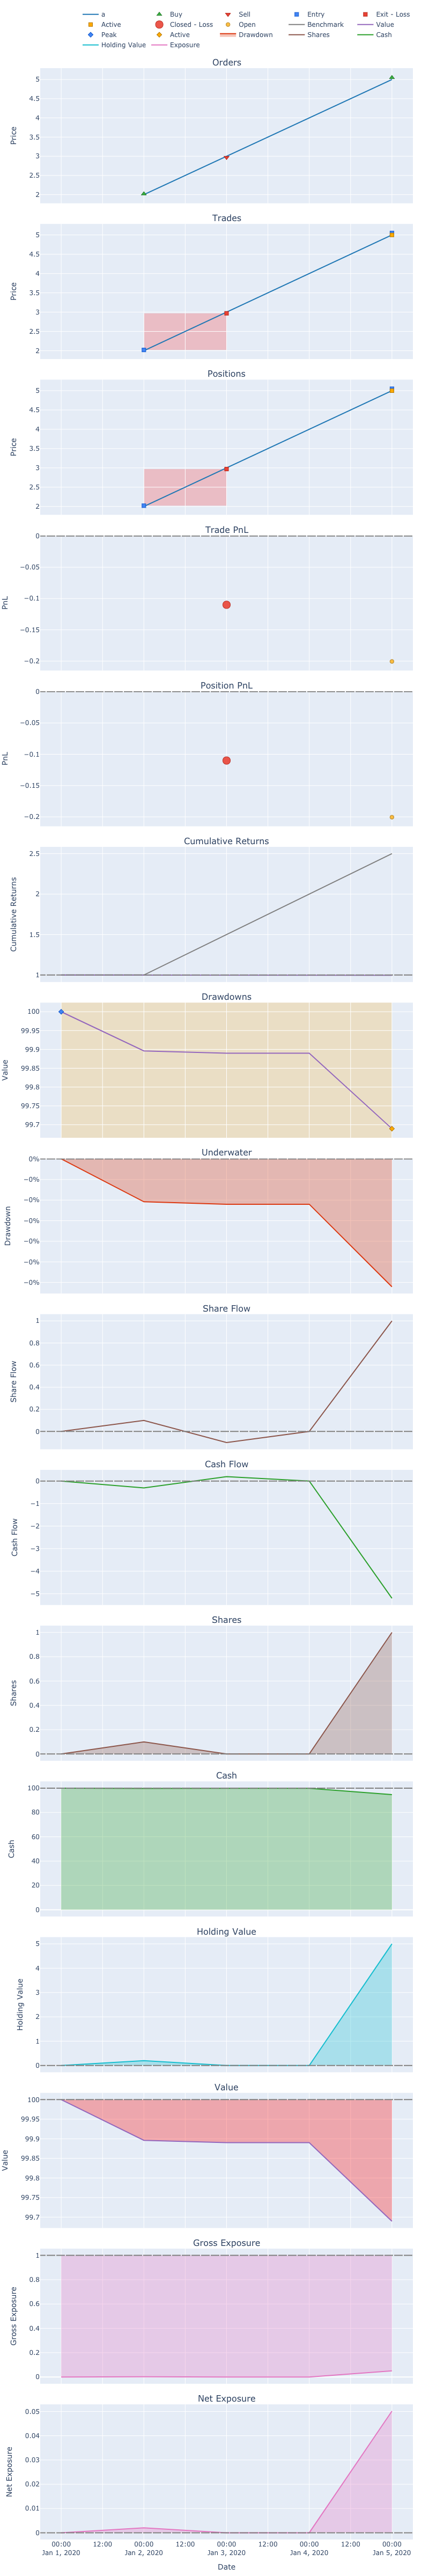

In [6]:
portfolio['a'].plot(subplots='all').show_png()

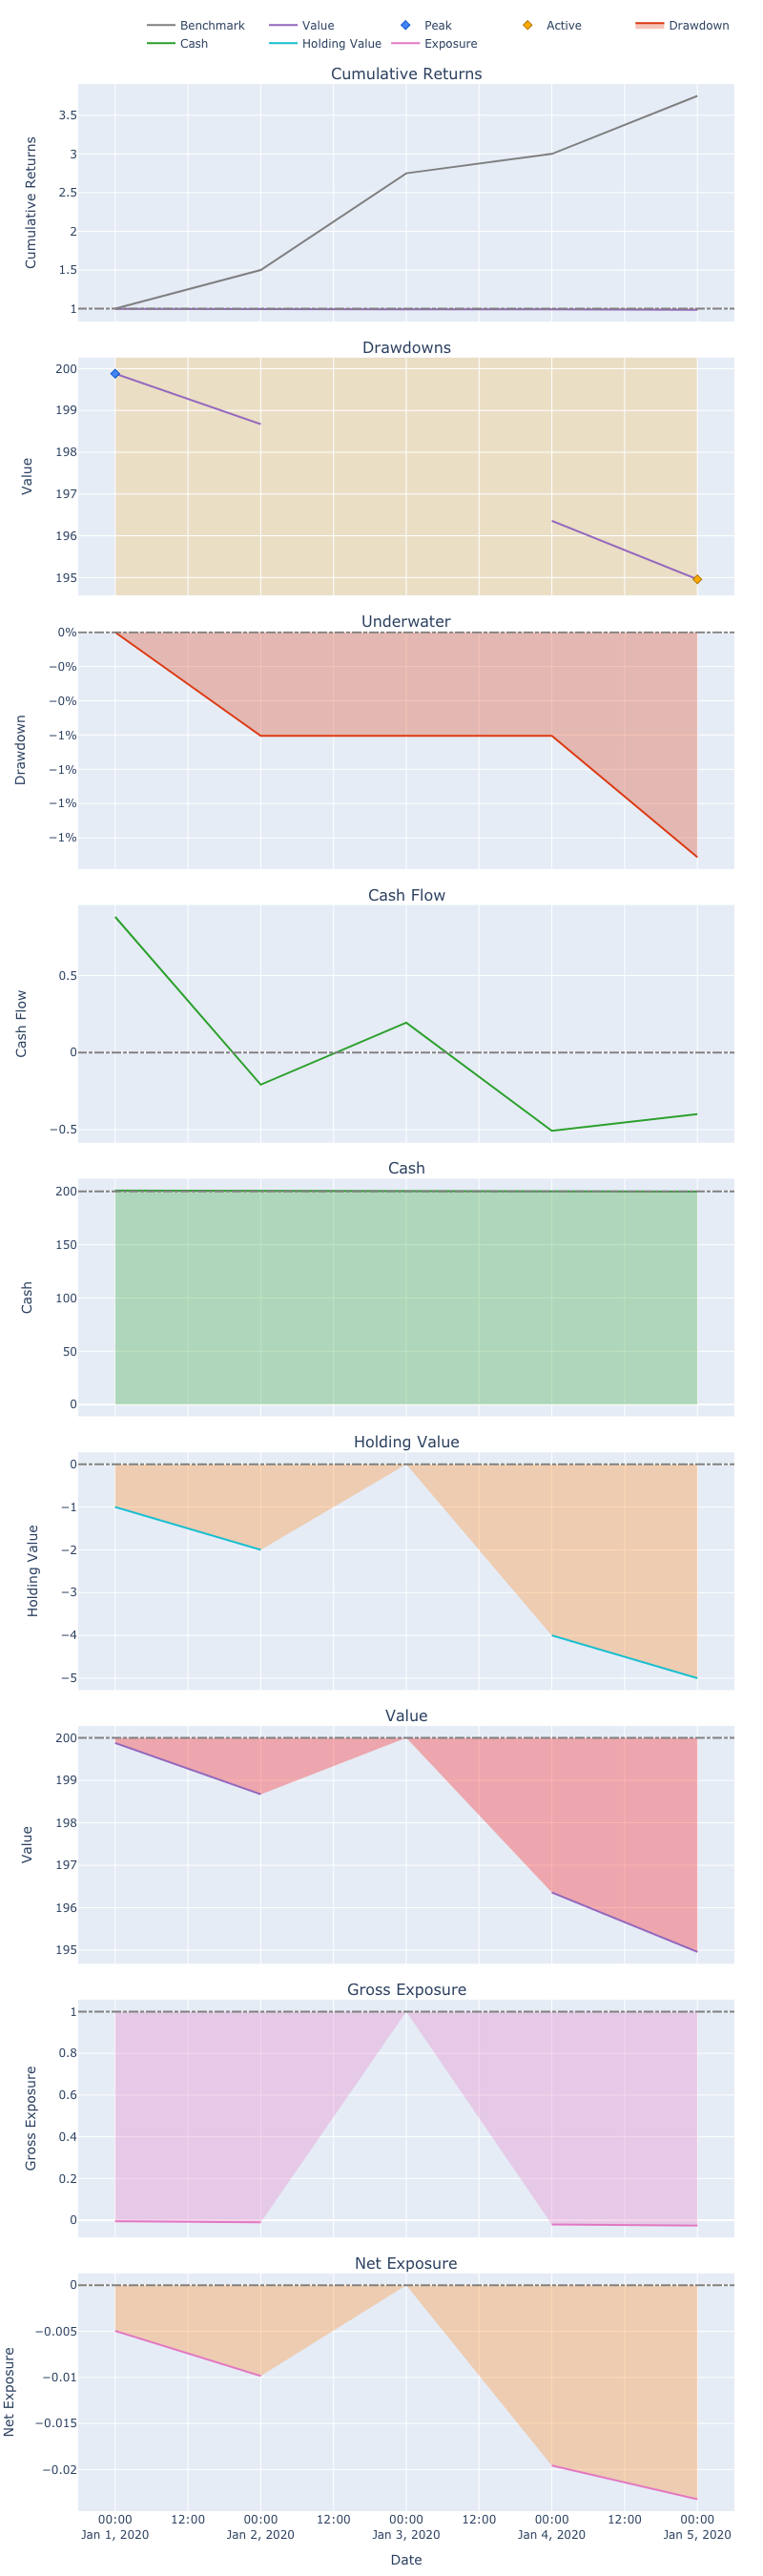

In [7]:
portfolio_grouped['first'].plot(subplots='all').show_png()

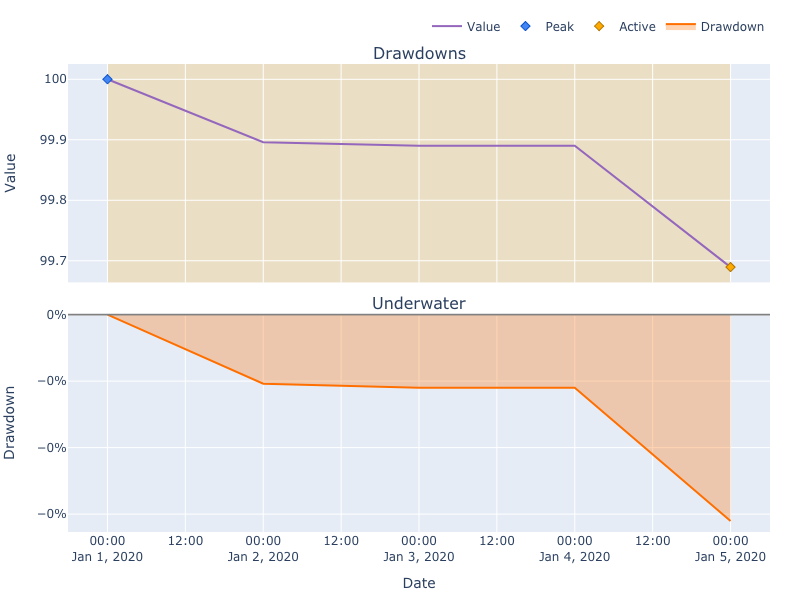

In [8]:
from vectorbt.utils.colors import adjust_opacity

portfolio['a'].plot(
    subplots=['drawdowns', 'underwater'],
    drawdowns_kwargs=dict(top_n=3),
    underwater_kwargs=dict(
        trace_kwargs=dict(
            line_color='#FF6F00',
            fillcolor=adjust_opacity('#FF6F00', 0.3)
        )
    )
).show_png()

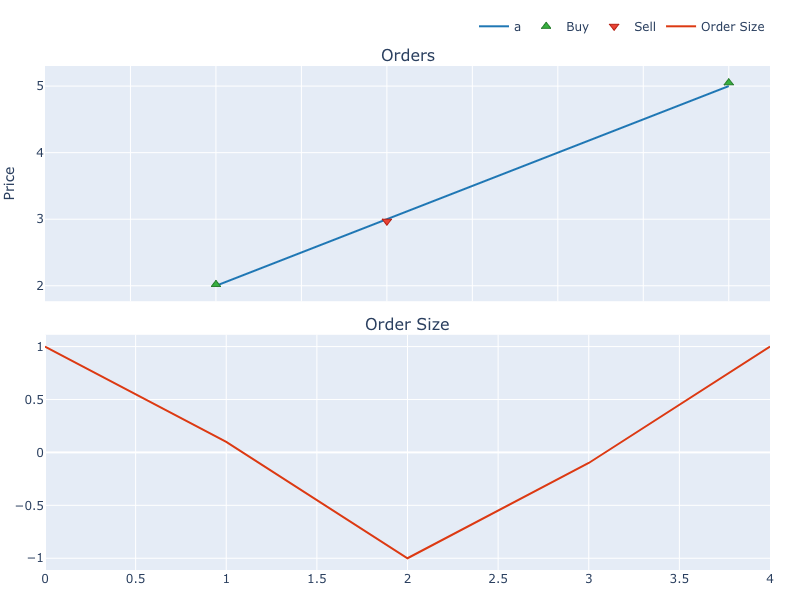

In [9]:
from vectorbt.defaults import color_schema

fig = portfolio['a'].plot(subplots=[
    'orders',
    ('order_size', dict(title='Order Size', can_plot_groups=False))  # placeholder
])

order_size.vbt.plot(name='Order Size', row=2, col=1, fig=fig).show_png()